In [ ]:
import numpy as np
import scipy.stats as stats
import statsmodels as st
from scipy.stats import expon, poisson, chi2, distributions, cauchy, norm, lomax, laplace, planck, skew, kurtosis, pareto
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF #dystr empiryczna
import random
import math
import statsmodels.api as sm
import pandas as pd
from scipy import optimize
from numba import jit
random.seed(12)
import time

# **Raport 1 - Symulacje Komputerowe**
## *Temat: Metody generowania zmiennych losowych*
## *Wykonawcy: Hanna Tłusty 268822, Marcelina Kosiorowska 268772*
## *Numer grupy: T00-22d* 
## *Data oddania sprawozdania: 8.05.2023r.*
----------------------------------------------------------------------------

## 1. Wstęp
Celem niniejszego raportu jest omówienie różnych metod generowania zmiennych losowych. 

Zmienną losową nazywamy taką zmienną, która przyjmuje wartości losowe. Wiele analiz statystycznych wymaga wygenerowania losowych wartości z rozkładu, co jest niezbędne do symulacji eksperymentów, modelowania danych i innych zastosowań.

W związku z powszechnym zastosowaniem zmiennych losowych, opracowano wiele metod ich generowania. W tym raporcie skupimy się na omówieniu kilku najważniejszych, a mianowicie:
* metoda odwrotnej dystrybuanty
* metoda akceptacji-odrzucenia
* metody generowania rozkładu normalnego $N(\mu, \sigma^2)$:
 * metoda Boxa–Mullera
 * metoda biegunowa
 * metoda akceptacji-odrzucenia przy użyciu rozkładu wykładniczego
* Algorytm Ziggurat

Dla każdej z tych metod przedstawimy opis jej działania oraz pokażemy generator opierający się na danej metodzie. Aby lepiej zobrazować działanie owych generatorów, przedstawimy kilka przykładów wykorzystania tych metod, a także przetestujemy generatory w kilku kategoriach: 
porównanie empirycznej i teoretycznej dystrybuanty, rozkładu prawdopodobieństwa, wykres kwantylowy, porównanie teoretycznej i empirycznej średniej oraz wariancji. 

W przypadku generowania rozkładu normalnego omówimy także skośność i kurtozę. Dokonamy także porównania metod generowania rozkładu normalnego ze względu na czas ich działania, by sprawdzić ich optymalność. 



Rozpoczniemy od metody odwracania dystrybuanty, ponieważ jest to jedna z najpopularniejszych a zarazem najefektywniejszych metod generowania zmiennych losowych.

## 2. Metoda odwracania dystrybuanty

### 2.1. Opis metody
Jest to metoda generowania zmiennej losowej $X$ o dystrybuancie $F_{X}$ poprzez generowanie zmiennej losowej z rozkładu jednostajnego, a następnie przekształceniu jej za pomocą odwrotnej dystrybuanty $F^{-1}_{X}$. \
W następnych podpunktach zostaną opisane algorytmy działania metody dla przypadku rozkładu dyskretnego oraz ciągłego.

#### 2.1.1. Algorytm metody dla rozkładu dyskretnego: 
Chcemy wygenerować zmienną losową $X$ o rozkładzie dyskretnym: 

$$P(X=i) = p_{i} ,\text{gdzie} \space i = 1,2,...,n $$ 
przy założeniu że:
$$ \sum_{i=1}^{n}p_{i} = 1 $$

Aby wygenerować ową zmienną należy postępować według poniższego <b>schematu</b>:
1. Generujemy $U \thicksim \mathcal{U}(0,1)$.


2. Znajdujemy $j$ takie, że: $ \sum_{i=1}^{j-1}p_{i} < U \leq \sum_{i=1}^{j}p_{i} $ i zwracamy $X = x_{j}$.
Równoważnie możemy zapisać: $ F_{X}(x_{j-1})< U \leq F_{X}(x_{j}) $.

#### 2.1.2. Algorytm metody dla rozkładu ciągłego:
W tym przypadku chcemy wygenerować ciągłą zmienną losową $X$ o niemalejącej dystrybuancie $F_{X}$. 

Wówczas **schemat algorytmu** wygląda następująco:
1. Generujemy $U \thicksim \mathcal{U}(0,1)$.
2. Wyznaczamy:
* $F^{-1}_{X}(U)$ jeżeli $F_{X}$ jest ściśle rosnąca
* $ \hat F_{X}^{-1}(U) = \inf ${$x \in R : F_{X}(x) \geq U $} jeśli $F_{X}$ nie jest ściśle rosnąca.
3. Zwracamy $X = F^{-1}_{X}(U)$ bądź $X = \hat F_{X}^{-1}(U)$.

### 2.2. Przykłady

#### 2.2.1. Rozkład dyskretny 

Pierwszym przykładem jaki omówimy będzie generowanie zmiennej z **rozkładu Plancka**. Wówczas owy rozkład prezentuje się następująco:

$X$ ~ *Planck*$(k,\lambda)$, gdzie $k,\lambda>0$ wtedy:


$$P(X = k)  = \frac{1- \exp(-\lambda)}{\exp(\lambda k)} = p_{k}$$

gdzie $k = 0, 1, ...$

Korzystając ze wzoru rekurencyjnego wyznaczamy:

$$P(X = k+1) = \frac{1- \exp(-\lambda)}{\exp(\lambda (k+1))} = \frac{1- \exp(-\lambda)}{\exp(\lambda k )\exp(\lambda)} = \frac{1}{\exp{\lambda}} \cdot P(X=k) $$
co możemy zapisać jako 
$$ p_{k+1} = \frac{1}{\exp{\lambda}} \cdot p_{k} $$
gdzie 
$$p_{0} = 1- \exp(-\lambda) $$

Korzystając z powyższych informacji oraz schematu algorytmu z podpunktu 1.1.1. możemy wyznaczyć algorytm dla tego konkretnego przykładu:
1. Generujemy $U \thicksim \mathcal{U}(0,1)$.

2. Sprawdzamy kolejne $j$ tak, aby: $ \sum_{i=1}^{j-1}p_{i} < U \leq \sum_{i=1}^{j}p_{i} $.

3. Gdy $j$ spełni nierówność to zwracamy $X = x_{j}$, a w przeciwnym razie inkrementujemy $j$ i znów powracamy do punktu 2.

W przypadku rozkładu Plancka, funkcja odwrotna do dystrybuanty nie ma postaci analitycznej, dlatego zastosujemy metodę iteracyjną do jej wyznaczenia. 

Kod programu do generowania $n-$próbek losowych z tego rozkładu wygląda następująco:


In [ ]:
def p_planck(lamb, k, p):
  if k == 0:
    return 1 - np.exp(-lamb)
  else:
    return p/np.exp(lamb)

In [ ]:
def rozklad_plancka(lamb, n, k = False):
    results =[]
    p = p_planck(lamb, 0, 0)
    ps = []
    for i in range(n):
        j = 0
        p = p_planck(lamb, 0, p)
        F = p
        u = random.random()
        while u > F:
            p = p_planck(lamb, i, p)
            F = F + p
            j = j+1
        results += [j]
        ps += [p]
    if k is True:
      return results, ps
    return results

**Teraz przeprowadzimy test poprawności działania omawianej metody.**

**Porównanie empirycznej i teoretycznej dystrybuanty**

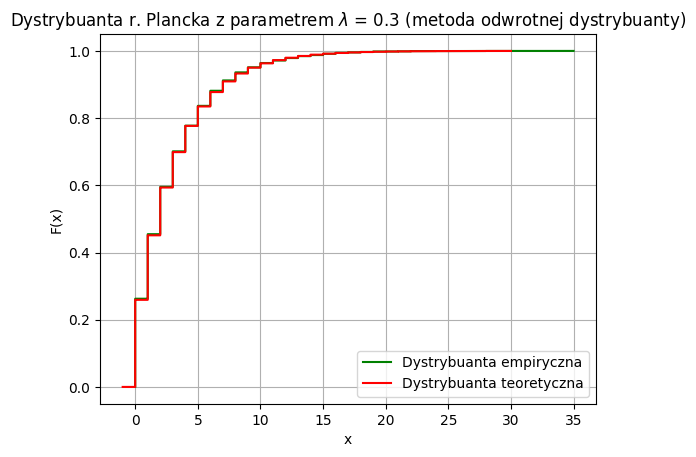

In [ ]:
lamb = 0.3
n = 10000
planc = rozklad_plancka(lamb, n)
x = np.linspace(-1, 30, n)

ecdf_p = ECDF(planc)
plt.step(ecdf_p.x, ecdf_p.y, 'g', label = "Dystrybuanta empiryczna")
plt.step(x, planck.cdf(x,  lamb), 'r',label = "Dystrybuanta teoretyczna")
plt.xlabel("x")
plt.ylabel("F(x)")
plt.grid()
plt.title("Dystrybuanta r. Plancka z parametrem $\lambda$ = {} (metoda odwrotnej dystrybuanty)".format(lamb))
plt.legend()

**Porównanie teoretycznej i empirycznej funkcji opisującej rozkład prawdopodobieństwa**

Text(0.5, 1.0, 'Rozkład prawdopodobieństwa r. Plancka z parametrem $\\lambda$ = 0.3')

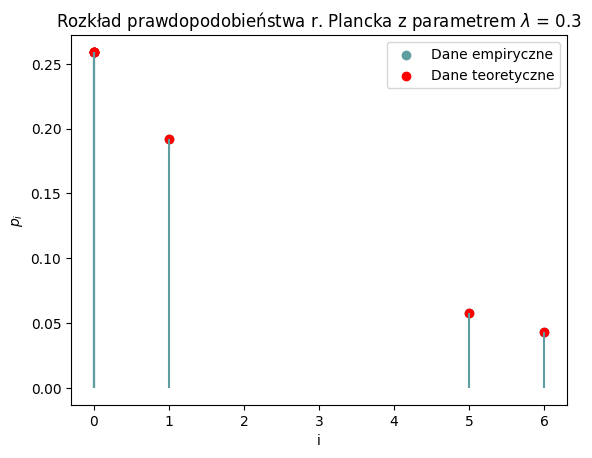

In [ ]:
lamb = 0.3
num = 8
x, probki = rozklad_plancka(lamb, num, True)
teor = planck.pmf(x, lamb)
                  
plt.scatter(x[1:], probki[1:], color = "cadetblue", label = "Dane empiryczne")
plt.scatter(x[1:], teor[1:], color = "red", label = "Dane teoretyczne")
plt.vlines(x[1:], 0, probki[1:], color = "cadetblue")
plt.legend()
plt.xlabel("i")
plt.ylabel("$p_i$")
plt.title("Rozkład prawdopodobieństwa r. Plancka z parametrem $\lambda$ = {}".format(lamb))

**Porównanie teoretycznej i empirycznej średniej i wariancji**

In [ ]:
pd.DataFrame([[np.mean(planc), planck.mean(lamb)],[np.var(planc), planck.var(lamb)]], index=["Średnia", "Wariancja"], columns=["Empirycznie", "Teoretycznie"])
#dla lambdy = 0.3

,Empirycznie,Teoretycznie
Średnia,2.836700,2.858296
Wariancja,10.963433,11.028151


#### 2.2.2. Rozkład ciągły
Dla rozkładu ciągłego podamy dwa przykłady generatorów rozkładu metodą odwrotnej dystrybuanty :

**a)** dla rozkładu Lomaxa

**b)** dla rozkładu Laplace'a

#### Ad. a) Rozkład Lomaxa

Niech zmienna $X$ będzie zmienną z **rozkładu Lomaxa**, zatem:

$X$ ~ *Lomax* $(α,\gamma)$
gdzie funkcja gęstości wyraża się wzorem:
$$f_X(x) = \frac{α}{\gamma}\left(1+\frac{x}{\gamma}\right)^{-(α+1)}$$
Aby zastosować metodę odwrotnej dystrybuanty dla rozkładu ciągłego, należy upewnić się, że $X$ jest ciągła o rosnącej dystrybuancie. Następnie trzeba wyznaczyć $F_X^{-1}(x)$. Całkując funkcję gęstości, otrzymujemy:
$$ F_X(x) = 1 -  \left(1+\frac{x}{\gamma}\right)^{-α},$$
Stąd:
$$ y = 1 -  \left(1+\frac{x}{\gamma}\right)^{-α}$$

$$ 1 - y = \frac{1}{\left(1+\frac{x}{\gamma}\right)^{α}}$$

$$ \frac{1}{1 - y }= \left(1+\frac{x}{\gamma}\right)^{α}$$

$$ \frac{1}{\sqrt[\alpha]{1 - y }}=1+\frac{x}{\gamma}$$
Więc ostatecznie:
$$x = \frac{\gamma}{\sqrt[\alpha]{1 - y }} - \gamma$$



Korzystając z algorytmu z podpunktu 1.1.2., możemy wyznaczyć algorytm dla tego konkretnego przykładu:
1. Generujemy $U \thicksim \mathcal{U}(0,1)$.
2. Wyznaczamy $F^{-1}_{X}(y) = \frac{\gamma}{\sqrt[\alpha]{1-y}} - \gamma$.

3. Zwracamy $X = \frac{\gamma}{\sqrt[\alpha]{U}} - \gamma$  (możemy tak zrobić, ponieważ $1-U$ ma ten sam rozkład co $U$).

Kod programu do generowania owego rozkładu wygląda następująco:

In [ ]:
def rozklad_lomaxa(alfa, gamma, n):
    result = []
    for i in range(n):
        u = random.random()
        result += [gamma/((u)**(1/alfa))]
    return np.array(result)

**Teraz przeprowadzimy test powyższego generatora.**


**Porówanie teoretycznej i empirycznej gęstości**

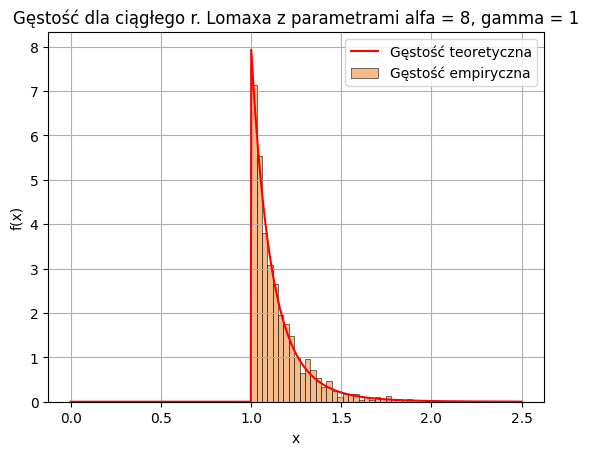

In [ ]:
n = 1000
alfa = 8
gamma = 1
x = np.linspace(0,2.5,n)
lom = rozklad_lomaxa(alfa, gamma, n)

plt.plot(x, lomax.pdf(x, alfa, gamma),'r',label = 'Gęstość teoretyczna')
sns.histplot(lom, kde=False, color='sandybrown', stat='density', label = "Gęstość empiryczna")

plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Gęstość dla ciągłego r. Lomaxa z parametrami alfa = {}, gamma = {}".format(alfa, gamma));

**Porównanie teoretycznej i empirycznej dystrybuanty**

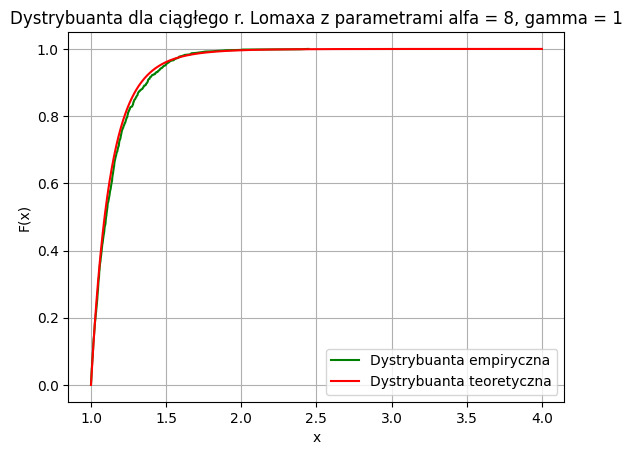

In [ ]:
n = 1000
alfa = 8
gamma = 1
x = np.linspace(1,4,n)

lom = rozklad_lomaxa(alfa, gamma, n)

ecdf_lo = ECDF(lom)
plt.plot(ecdf_lo.x, ecdf_lo.y, 'g',label = "Dystrybuanta empiryczna")
plt.plot(x, lomax.cdf(x, alfa, gamma) ,'r', label = 'Dystrybuanta teoretyczna')
plt.legend()
plt.xlabel("x")
plt.ylabel("F(x)")
plt.grid()
plt.title("Dystrybuanta dla ciągłego r. Lomaxa z parametrami alfa = {}, gamma = {}".format(alfa,gamma));

**Porównanie korelacji między rozkładem wysymulowanym a teoretycznym**

Text(0.5, 1.0, 'Wykres kwantylowy dla ciągłego r. Lomaxa')

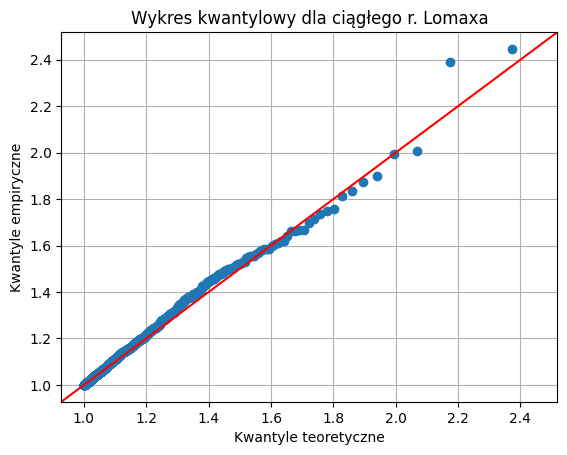

In [ ]:
sm.qqplot(np.array(lom), dist = lomax(alfa,gamma), line = '45');
plt.grid()
plt.xlabel("Kwantyle teoretyczne")
plt.ylabel("Kwantyle empiryczne")
plt.title("Wykres kwantylowy dla ciągłego r. Lomaxa")

**Porównanie teoretycznej i empirycznej średniej i wariancji**



In [ ]:
pd.DataFrame([[np.mean(lom), lomax.mean(alfa, gamma)],[np.var(lom), lomax.var(alfa, gamma)]], index=["Średnia", "Wariancja"], columns=["Empirycznie", "Teoretycznie"])


,Empirycznie,Teoretycznie
Średnia,1.152742,1.142857
Wariancja,0.027602,0.027211


#### Ad. b) Rozkład Laplace'a

Niech zmienna $X$ będzie z **rozkładu Laplace'a**, wtedy:

$X$ ~ $L(\mu,\lambda)$ 
a funkcja gęstości ma postać:

$$f_X(x) = \frac{\lambda}{2} \cdot \frac{1}{\exp({\lambda|x-\mu|})}$$

Do użycia metody odwrotnej dystrybuanty dla rozkładu ciągłego, należy upewnić się, że $X$ jest zadana funkcją o rosnącej dystrybuancie. 

Przekształcając gęstość za pomocą całki otrzymujemy wzór na dystrybuantę:

$$F_X(x) = \begin{cases} \frac{1}{2}\exp\left(\frac{x-\mu}{\lambda}\right) &\text{dla} \ x\le\mu \\ 1-\frac{1}{2}\exp\left(-\frac{x-\mu}{\lambda}\right) &\text{dla} \ x>\mu
\end{cases}$$

Teraz przejdziemy do wyznaczenia funkcji odwrotnej dla $x \le \mu$:
$$ y = \frac{1}{2}\exp\left(\frac{x-\mu}{\lambda}\right)$$

$$\ln(2y) = \frac{x-\mu}{\lambda}$$

$$ x = \lambda \ln(2y) + \mu$$

Natomiast dla $x > \mu$:
$$ y = 1-\frac{1}{2}\exp\left(-\frac{x-\mu}{\lambda}\right)$$

$$ 1- y = \frac{1}{2}\exp\left(-\frac{x-\mu}{\lambda}\right)$$

$$ 2 - 2y = \exp\left(-\frac{x-\mu}{\lambda}\right)$$

$$\ln(2-2y) = -\frac{x-\mu}{\lambda}$$

$$ x = \mu - \lambda \ln(2-2y)$$

Korzystając z powyższych wzorów oraz z schematu algorytmu z punktu 1.1.2. kreujemy następujący algorytm do generowania rozkładu Laplace'a:
1. Generujemy $U \thicksim \mathcal{U}(0,1)$.
2. Sprawdzamy czy $U \le \mu$:
  - Jeśli *tak* to wstawiamy: $X =  \lambda \ln(2U) + \mu$
  - Jeśli *nie* to wstawiamy: $X = \mu - \lambda \ln(2-2U)$

Kod programu generującego rozkład Laplace'a wygląda następująco:

In [ ]:
def rozklad_laplace(mi, lamb, n):
    result = []
    for i in range(n):
        u = random.random()
        if u <= mi:
          result += [lamb*np.log(2*u) + mi]
        else:
          result += [mi - lamb*np.log(2-2*u)]
    return result

**Teraz przeprowadzimy test poprawności działania omawianej metody na przykładzie generowania rozkładu Laplace'.**

(Analogicznie jak dla rozkładu Lomaxa)

**Porównanie gęstości teoretycznej i empirycznej**

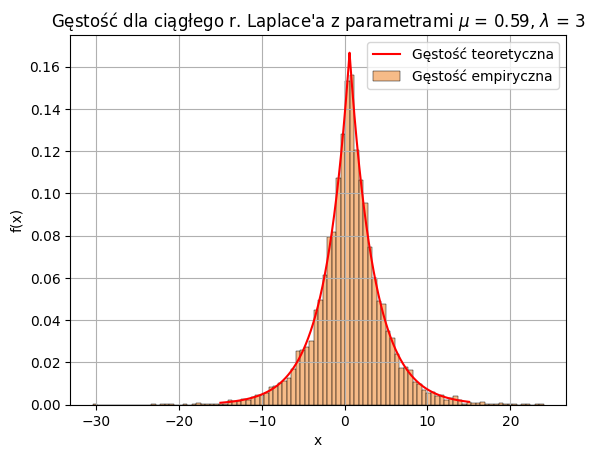

In [ ]:
n = 10000
x = np.linspace(-15,15,n)
mi = 0.59
lamb = 3
lap = rozklad_laplace(mi, lamb, n)

plt.plot(x, laplace.pdf(x, mi, lamb),'r',label = 'Gęstość teoretyczna')
sns.histplot(lap, kde=False, color='sandybrown', stat='density', label = "Gęstość empiryczna", bins="sqrt")
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.title("Gęstość dla ciągłego r. Laplace'a z parametrami $\mu$ = {}, $\lambda$ = {}".format(mi,lamb));

**Porównanie teoretycznej i empirycznej dystrybuanty**

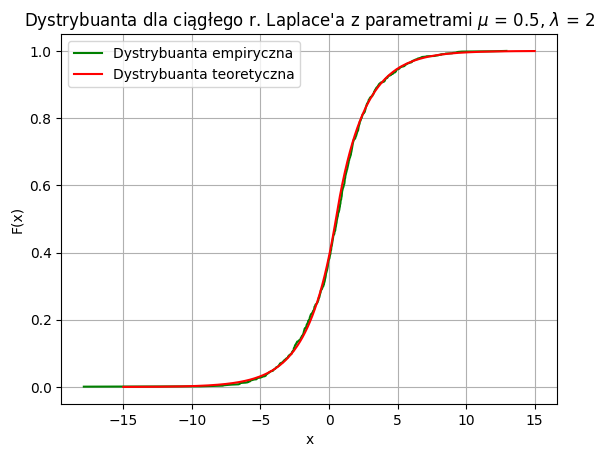

In [ ]:
n = 1000
x = np.linspace(-15,15,n)
mi = 0.5
lamb = 2
lap = rozklad_laplace(mi, lamb, n)

ecdf_l = ECDF(lap)
plt.plot(ecdf_l.x, ecdf_l.y, 'green',label = "Dystrybuanta empiryczna")
plt.plot(x, laplace.cdf(x, mi, lamb) ,'red', label = 'Dystrybuanta teoretyczna')
plt.legend()
plt.xlabel("x")
plt.ylabel("F(x)")
plt.grid()
plt.title("Dystrybuanta dla ciągłego r. Laplace'a z parametrami $\mu$ = {}, $\lambda$ = {}".format(mi,lamb));

**Porównanie korelacji między rozkładem wysymulowanym a teoretycznym**

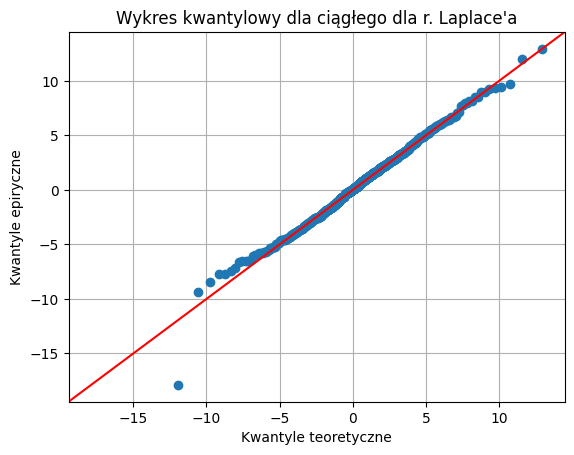

In [ ]:
sm.qqplot(np.array(lap), dist = laplace(mi, lamb), line = '45');
plt.xlabel("Kwantyle teoretyczne")
plt.ylabel("Kwantyle epiryczne")
plt.title("Wykres kwantylowy dla ciągłego dla r. Laplace'a")
plt.grid()
plt.show()

**Porównanie teoretycznych i empirycznych średnich, wariancji**

In [ ]:
pd.DataFrame([[np.mean(lap),laplace.mean(mi, lamb)],[np.var(lap), laplace.var(mi, lamb)]], index=["Średnia", "Wariancja"], columns=["Empirycznie", "Teoretycznie"])


,Empirycznie,Teoretycznie
Średnia,0.548877,0.5
Wariancja,7.792579,8.0


### 2.3. Wnioski

Na podstawie przeprowadzonych symulacji i obserwacji wyników jednego rozkładu dyskretnego i dwóch rozkladów ciągłych możemy stwierdzić, że metoda odwrotnej dystrybuanty w sposób satysfakcjonujący generuje zadane rozkłady. 

Możemy zauważyć, że rozbieżnosci w wartościach teoretycznych i empirycznych średnich i wariancji nie przekraczają 3%, co jest zadowalającym wynikiem. 

Najważniejszą wadą metody odwrotnej dystrybuanty jest fakt, że nie zawsze jesteśmy w stanie wyznaczyć funkcję odwrotnej dystrybuanty w postaci jawnej, co mogliśmy zaobserwować w przykładzie z rozkładem Plancka. 

## 3. Metoda akceptacji-odrzucenia

### 3.1. Opis metody
W uproszczeniu jest to metoda, która polega na generowaniu zmiennej losowej $X$ przy użyciu zmiennych z innych rozkładów. 
W następnych podpunktach zostaną opisane algorytmy działania dla przypadku rozkładu dyskretnego oraz ciągłego.

#### 3.1.1. Algorytm metody dla przypadku dyskretnego

Chcemy wygenerować zmienną losową X o rozkładzie dyskretnym: \
$P(X=i) = p_{i} \space $gdzie$ \space i = 1, 2,...,n$
\
\
Aby móc wykorzystać tę metodę musimy: 
- umieć generować zmienną losową Y o rozkładzie: $P(Y=i) = q_{i} \space $gdzie $\space i = 1, 2,...,n$
- potrafić wyznaczyć stałą $c$ taką, że $c = \max\frac{P(X=i)}{P(Y=i)} = \max\frac{p_{i}}{q_{i}}$ dla każdego $i$.

Jeśli są spełnione te założenia, to możemy zastosować algorytm. 

**Schemat algorytmu:**
1. Generujemy zmienną losową $Y$.
2. Generujemy $U \thicksim \mathcal{U}(0,1)$.
3. Jeżeli $U \leq \frac{p_{Y}}{cq_{Y}}$ to zwróć $X=Y$, w przeciwnym wypadku wracamy do punktu 1.

#### 3.1.2. Algorytm metody dla przypadku ciągłego

Metodę akceptacji odrzucenia możemy wykorzystać też dla przypadku ciągłego. 
Zatem chcemy wygenerować zmienną losową X o gęstości  $f(x)$.
Aby skorzystać z tej metody należy:
- umieć generować zmienną losową Y o gęstości $g(x)$
- zmienne $X$ i $Y$ muszą być skupione na tym samym zbiorze 
- potrafić wyznaczyć stałą $c$ taką, że $c \geq \sup\frac{f(x)}{g(x)}$ gdzie $x$ należą do zbioru, na którym są skupione zmienne $X$ i $Y$

Jeżeli spełniamy te założenia, to możemy zastosować algorytm.

**Schemat algorytmu:**
1. Generujemy zmienną losową $Y$. 
2. Generujemy $U \thicksim  \mathcal{U}(0,1)$.
3. Jeżeli $U \leq \frac{f(Y)}{cg(Y)}$ to zwróć $X=Y$, w przeciwnym wypadku wracamy do punktu 1.

### 3.2. Przykłady 

#### 3.2.1. Rozkład dyskretny


Dla rozkładu dyskretnego podamy dwa przykłady generatorów rozkładu metodą akceptacji-odrzucenia :

<b>a)</b> dla rozkładu opisanego przez wartości jakie przyjmuje zmienna losowa wraz z prawdopodobieństwem wystąpienia każdej z nich

<b>b)</b> dla rozkładu Bernoulliego

Kod programu dla metody akceptacji odrzucenia w przypadku dyskretnym jest następujący:

In [ ]:
def metoda_akc_odrz(p, n):
    
    num = len(p)
    q = [0] * num
    for i in range(0, num): 
        q[i] = 1 / num
    
    # wyznaczanie stałej c
    c = max(p) / max(q)
    wynik = np.zeros(n)
    i = 0
    while i < n:
        # 1.
        u1 = np.random.uniform(0, 1)
        Y = math.ceil(num * u1)
        
        # 2.
        u2 = np.random.uniform(size=1)
        
        # 3.
        if u2 <= p[Y - 1] / (c * q[0]):
            wynik[i] = Y
            i += 1
            
    wynik = sorted(wynik)

    ilosci = {}
    for i in wynik:
        if i in ilosci:
            ilosci[i] += 1
        else:
            ilosci[i] = 1

    pk_e = []
    for i in range(1, len(p) + 1):
        if i in ilosci:
            pk_e.append(ilosci[i] / n)
        else:
            pk_e.append(0)
    return pk_e

#### Ad. a) Rozkład podany w tabeli

Niech $X$ ma **rozkład podany w tabeli**:


|$n$    | 1    | 2   | 3   | 4    | 5    | 6    |
|-------|------|-----|-----|------|------|------|
|$x_{n}$| -2   | -1  | 0   | 1    | 2    | 3    |
|$p_{n}$| 0.09 | 0.2 | 0.3 | 0.22 | 0.16 | 0.03 |

I odczytujemy go w następujący sposób:
<center>$P(X = 0) = 0.3$ ,  $P(X = 3) = 0.03$ itd. </center>

- Do generowania zmiennej $X$ potrzebujemy zmiennej, która będzie skupiona na tym samym zbiorze. Aby wypełnić ten cel najprościej wygenerować zmienną $Y$ o rozkładzie jednostajnym dyskretnym takim że:

<center>$P(Y=-2)=P(Y=-1)=P(Y=0)=P(Y=1)=P(Y=2)=P(Y=3)=\frac{1}{6}$</center> 

- Teraz wyznaczamy stałą $c$ pamiętając, że $c= \underset{i}{\max}\frac{p_{i}}{q_{i}}$. Wyznaczona stała $c$ wynosi $1.8$.

Skoro spełnione są wszystkie potrzebne założenia, to możemy stosować **algorytm**:

1. Generujemy zmienną losową $Y \thicksim \lceil 6 \cdot \mathcal{U}(0,1)\rceil$.
2. Generujemy $U \thicksim  \mathcal{U}(0,1)$.
3. Jeżeli $U \leq \frac{p_{Y}}{cq_{Y}} = \frac{p_{Y}}{1.8*\frac{1}{6}} = \frac{10}{3}p_{Y}$ to zwróć $X=Y$, w przeciwnym wypadku wróć do punktu 1.

**Teraz przejdziemy do testowania metody akceptacji-odrzucenia dla rozkładu dyskretnego**.

Test przeprowadzimy według schematu analogicznego jak dla metody odwrotnej dystrybuanty.

**Porówanie teoretycznej i empirycznej funkcji opisującej rozkład prawdopodobieństwa**

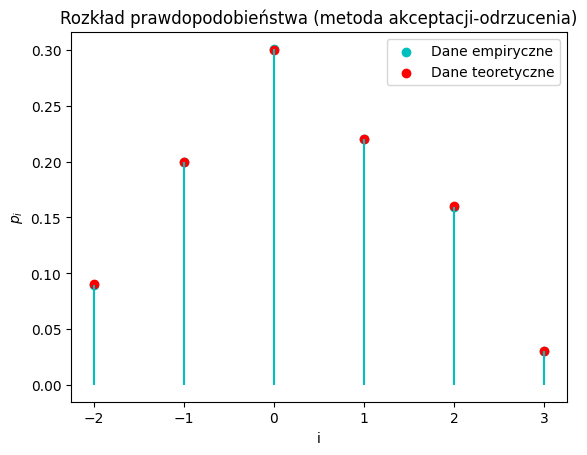

In [ ]:
n = 100000

prawd = [0.09, 0.2, 0.3 ,0.22, 0.16, 0.03]
x = np.arange(-2, 4, 1)
probki = metoda_akc_odrz(prawd, n)
plt.scatter(x, probki, color="c", label="Dane empiryczne")
plt.scatter(x, prawd, color="red", label="Dane teoretyczne")
plt.vlines(x, 0, probki, color="c")
plt.xlabel("i")
plt.ylabel("$p_i$")
plt.title("Rozkład prawdopodobieństwa (metoda akceptacji-odrzucenia)")
plt.legend()
plt.show()

**Porównanie empirycznej i teoretycznej dystrybuanty**

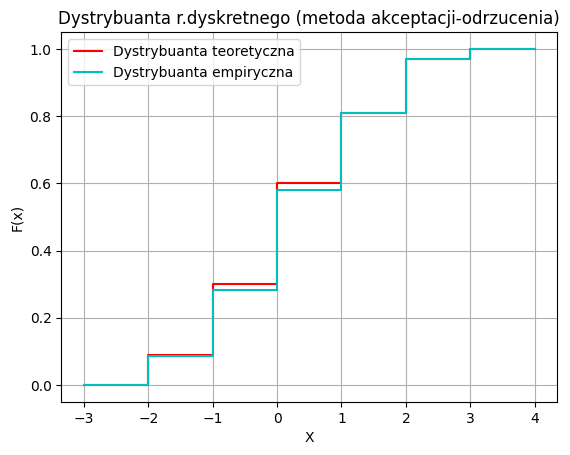

In [ ]:
n = 10000
probki = metoda_akc_odrz(prawd, n)
probki.reverse()
probki.extend([0, 0])
probki.reverse()

pr_teor = [0, 0, 0.09, 0.21, 0.3 ,0.21, 0.16, 0.03]

x = np.arange(-3,5, 1)
y_t = np.cumsum(pr_teor)
y_e = np.cumsum(probki)

plt.step(x, y_t, label="Dystrybuanta teoretyczna", color="r")
plt.step(x, y_e, label="Dystrybuanta empiryczna", color="c")
plt.xlabel("X")
plt.ylabel("F(x)")
plt.title("Dystrybuanta r.dyskretnego (metoda akceptacji-odrzucenia)")
plt.legend()
plt.grid()
plt.show()

**Porównanie teoretycznej i empirycznej średniej i wariancji**

Do wyznaczenia średniej i wariancji użyjemy następujących wzorów:
* Średnia
$$ \mathrm{E}X = \sum_{n}x_{n}p_{n}$$
* Wariancja
$$\mathrm{Var}X = \sum_{n}x_{n}^{2}p_{n} - (\mathrm{E}X)^2$$

In [ ]:
n = 100000

x_n = [-2, -1, 0, 1, 2, 3]
p_n_teor = [0.09, 0.2, 0.3 ,0.22, 0.16, 0.03]
p_n_empir = metoda_akc_odrz(p_n_teor, n)

xp_teor = []
xp_empir = []
x2p_teor = []
x2p_empir = []
for i in range(len(x_n)):
    xp_teor.append(x_n[i]*p_n_teor[i])
    xp_empir.append(x_n[i]*p_n_empir[i])
    x2p_teor.append((x_n[i]**2)*p_n_teor[i])
    x2p_empir.append((x_n[i]**2)*p_n_empir[i])
    
sred_teor = sum(xp_teor)
sred_empir = sum(xp_empir)
war_teor = sum(x2p_teor) - (sred_teor)**2
war_empir = sum(x2p_empir) - (sred_empir)**2

pd.DataFrame([[sred_empir, sred_teor],[war_empir, war_teor]], index=["Średnia", "Wariancja"], columns=["Empirycznie", "Teoretycznie"])

,Empirycznie,Teoretycznie
Średnia,0.247220,0.2500
Wariancja,1.626542,1.6275


#### Ad. b) Rozkład Bernoulliego
Niech zmienna $X$ będzie z **rozkładu Bernoulliego** $B (7, 0.55) $ dla którego prawdopodobieństwo dane jest wzorem:

$$P(X=k) = \binom{n}{k}p^{k}(1-p)^{n-k} = \binom{7}{k}(0.55)^{k}(0.45)^{7-k}$$ gdzie $k=0,1,..,7$

Z definicji rozkładu Bernoulliego wiadomo, iż jest to prawdopodobieństwo uzyskania $k$ sukcesów w $7$ próbach. 

- Do generowania zmiennej $X$ potrzebujemy zmiennej, która będzie skupiona na tym samym zbiorze. Aby wypełnić ten cel najprościej wygenerować zmienną $Y$ o rozkładzie jednostajnym dyskretnym takim że:

$$P(Y=0)=P(Y=1)=...=P(Y=n)=\frac{1}{n}$$

$$P(Y=0)=P(Y=1)=P(Y=2)=P(Y=3)=P(Y=4)=P(Y=5)=P(Y=6)=P(Y=7)=\frac{1}{7}$$

- Teraz wyznaczamy stałą $c$ pamiętając, że $c= \underset{i}{\max}\frac{P(X=i)}{P(Y=i)}$, wyznaczamy że $c=\frac{P(X=4)}{P(Y=4)} \approx 2.043$.

Skoro spełnione są wszystkie potrzebne założenia to możemy stosować **algorytm**:

1. Generujemy zmienną losową $Y \thicksim \lceil7\cdot \mathcal{U}(0,1)\rceil$ 
2. Generujemy $U \thicksim  \mathcal{U}(0,1)$.
3. Jeżeli $U \leq \frac{p_{Y}}{cq_{Y}} $ to zwróć $X=Y$, a w przeciwnym wypadku wróć do punktu 1.

Kod programu generującego rozkład Bernoulliego wygląda następująco:





In [ ]:
def bernoulli_generator(n, p):
    n = n+1
    prawds = np.zeros(n)
    for k in range(n):
        dwumian = math.factorial(n)/(math.factorial(n-k)*math.factorial(k))
        prawd = dwumian*p**k*(1-p)**(n-k)
        prawds[k] = prawd
    return prawds


**Teraz przejdziemy do testowania generatora:**

**Porównanie funkcji opisującej r. prawdopodobieństwa**

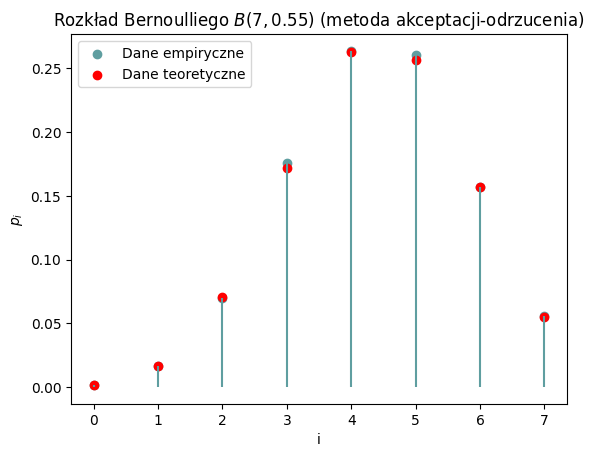

In [ ]:
num = 100000
n = 7
p = 0.55

prawd = bernoulli_generator(n, p)
x = np.arange(0,n+1,1)
probki = metoda_akc_odrz(prawd, num)

plt.scatter(x, probki, color="cadetblue", label="Dane empiryczne")
plt.scatter(x, prawd, color="red", label="Dane teoretyczne")
plt.vlines(x, 0, probki, color="cadetblue")
plt.xlabel("i")
plt.ylabel("$p_i$")
plt.title("Rozkład Bernoulliego $B({}, {})$ (metoda akceptacji-odrzucenia)".format(n,p))
plt.legend()
plt.show()

**Porównanie empirycznej i teoretycznej dystrybuanty**

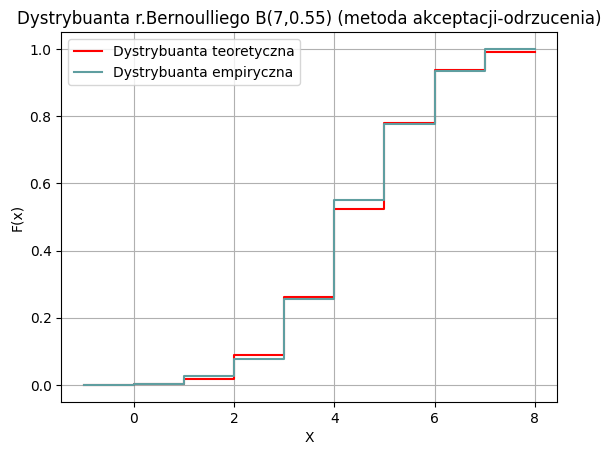

In [ ]:
num = 1000
n = 7
p = 0.55
pr = bernoulli_generator(n, p)
probki = metoda_akc_odrz(pr, num)

zmienne = np.arange(-1,n+2,1)
probki = metoda_akc_odrz(pr, num)
probki.reverse()
probki.extend([0, 0])
probki.reverse()

pr_teor = list(bernoulli_generator(n,p))
pr_teor.reverse()
pr_teor.extend([0, 0])
pr_teor.reverse()
y_t = np.cumsum(pr_teor)
y_e = np.cumsum(probki)

plt.step(zmienne, y_t, label="Dystrybuanta teoretyczna", color="red")
plt.step(zmienne, y_e, label="Dystrybuanta empiryczna", color="cadetblue")
plt.xlabel("X")
plt.ylabel("F(x)")
plt.title("Dystrybuanta r.Bernoulliego B({},{}) (metoda akceptacji-odrzucenia)".format(n,p))
plt.legend()
plt.grid()
plt.show()

**Porównanie teoretycznej i empirycznej średniej i wariancji**

In [ ]:
n = 7
p = 0.55
pr_teor = bernoulli_generator(n, p)
pr_empir = metoda_akc_odrz(pr_teor, num)

pd.DataFrame([[np.mean(pr_empir),np.mean(pr_teor)],[np.var(pr_empir), np.var(pr_teor)]], index=["Średnia", "Wariancja"], columns=["Empirycznie", "Teoretycznie"])


,Empirycznie,Teoretycznie
Średnia,0.125000,0.123953
Wariancja,0.009973,0.009306


#### 3.2.2. Rozkład ciągły 

Dla rozkładu ciągłego podamy podamy przykład dla **rozkładu zmiennej losowej o gęstości $f(x)$.**

Niech zmienna $X$ ma rozkład o gęstości $f(x) = \ln(\sqrt{5}) \cdot \sin(x) \cdot \cos(x) \cdot 5^{\sin^{2}(x)}  
\mathbb{1}_{(0, \frac{\pi}{2})} $. 

- Do generowania zmiennej $X$ potrzebujemy zmiennej, która będzie skupiona na tym samym zbiorze. Użyjemy do tego zmiennej $Y$ o rozkładzie jednostajnym $\mathcal{U}(0,1)$, której funkcja gęstości to:

$$g(y) = \frac{2}{\pi} \mathbb{1}_{(0, \frac{\pi}{2})} $$

- Teraz wyznaczamy stałą $c$ pamiętając, że $c \geq \underset{x \in (0,\frac{\pi}{2})}{\sup}\frac{f(x)}{g(x)} $. Stałą $c$ wyznaczymy optymalnie, zatem zapisujemy równość:

$$c=\underset{x \in (0,\frac{\pi}{2})}{\sup}\frac{f(x)}{g(x)} = \underset{x \in (0,\frac{\pi}{2})}{\sup}\frac{\pi \cdot \ln(\sqrt{5}) \cdot \sin(x) \cdot \cos(x) \cdot 5^{\sin^{2}(x)}}{2} ≈ 0.1281  $$


Stosujemy się teraz do podanego wcześniej algorytmu:

**Schemat algorytmu:**
1. Generujemy zmienną losową $Y \thicksim \mathcal{U}(0,\frac{\pi}{2})$. 
2. Generujemy $U \thicksim  \mathcal{U}(0,1)$.

3. Jeżeli $U \leq \frac{f(Y)}{cg(Y)} = \frac{\ln(\sqrt{5}) \cdot \sin(Y) \cdot \cos(Y) \cdot 5^{\sin^{2}(Y)} \cdot \pi }{c \cdot 2} $ to zwróć $X=Y$, w przeciwnym wypadku wróć do punktu 1.

Program generujący wartości funkcji $f(x)$ to:

In [ ]:
def f_gestosci(x):
    return np.log(np.sqrt(5))* np.sin(x) * np.cos(x)*5**(np.sin(x)**2)

Kod programu generujący zmienne z rozkładu o gęstości $f(x)$ na przedziale $(a,b)$ metodą akceptacji-odrzucenia jest następujący:

In [ ]:
def generator_f(a, b, n):
    
    wynik = np.zeros(n)
    
    x0 = optimize.fminbound(lambda x: -f_gestosci(x), a, b)
   
    max_f = f_gestosci(x0)
    
    i = 0
    while i < n:

        u1 = np.random.uniform(a, b)
        u2 = np.random.uniform(0, max_f)
        if u2 <= f_gestosci(u1):
            wynik[i] = u1
            i += 1
    return wynik

**Teraz przejdziemy do testowania generatora:**

**Porównanie gęstości teoretycznej i empirycznej**

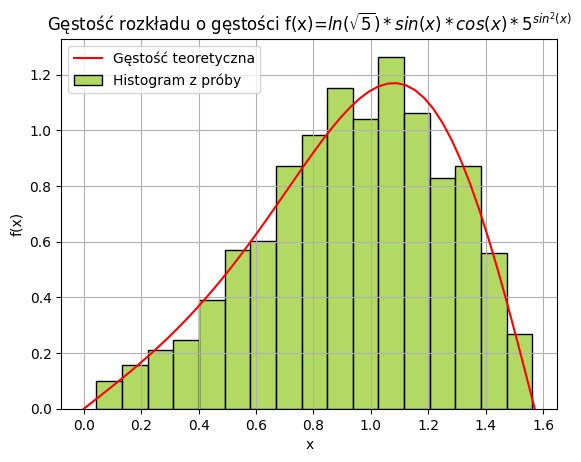

In [ ]:
n = 1000
a = 0
b = np.pi/2
probki = generator_f(a, b, n)

sns.histplot(probki, kde=False, color='yellowgreen', label='Histogram z próby', stat='density')

plt.title('Gęstość rozkładu o gęstości f(x)=' + r'$ln(\sqrt{5})*sin(x) * cos(x)*5^{sin^{2}(x)}$')

d = np.linspace(a, b)
plt.plot(d, f_gestosci(d), "red", label="Gęstość teoretyczna")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.legend()
plt.show()

**Porównanie teoretycznej i empirycznej dystrybuanty**

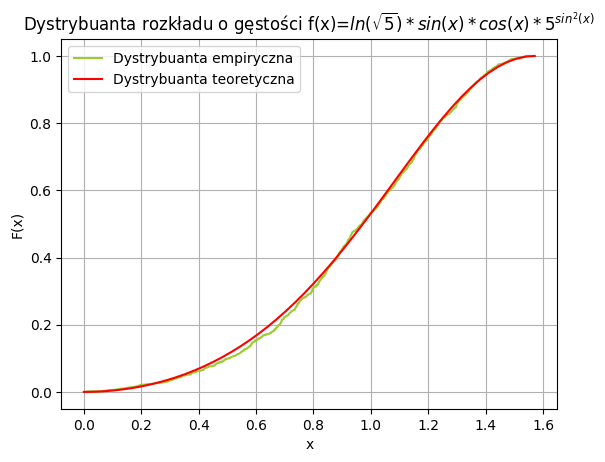

In [ ]:
# wzór na funkcję dystrybuanty 
def f_dystr(x):
    return (1/4)*(5**(np.sin(x)**2)-1)

n = 1000
a = 0
b = np.pi/2
x = generator_f(a, b,n )

ecdf = ECDF(x)
plt.plot(ecdf.x, ecdf.y, label="Dystrybuanta empiryczna", color="yellowgreen")
d = np.linspace(a,b)
plt.plot(d, f_dystr(d),label="Dystrybuanta teoretyczna", color="red")
plt.ylabel("F(x)")
plt.xlabel("x")
plt.legend()
plt.grid()
plt.title('Dystrybuanta rozkładu o gęstości f(x)=' + r'$ln(\sqrt{5})*sin(x) * cos(x)*5^{sin^{2}(x)}$')
plt.show()

**Porównanie przybliżenia rozkładu empirycznego oraz teoretycznego**

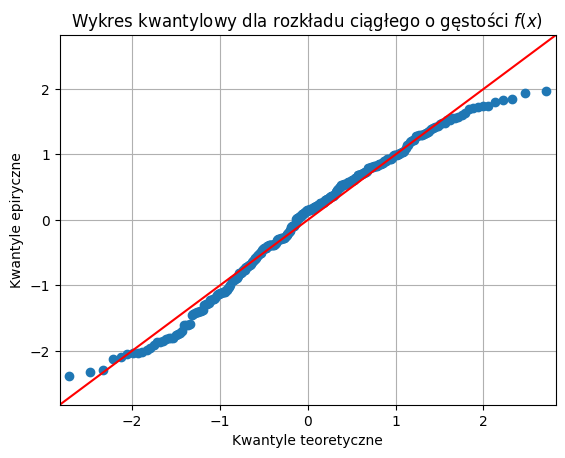

In [ ]:
n = 300
x = generator_f(a,b,n)

sm.qqplot(x, line='45', fit=True)

plt.xlabel("Kwantyle teoretyczne")
plt.ylabel("Kwantyle epiryczne")
plt.title("Wykres kwantylowy dla rozkładu ciągłego o gęstości $f(x)$ ")
plt.grid()


**Średnia i wariancja**

In [ ]:
n = 1000
a = 0
b = np.pi/2
proba = generator_f(a,b,n)
pd.DataFrame([[np.mean(proba)],[np.var(proba)]], index=["Średnia", "Wariancja"], columns=["Empirycznie"])

,Empirycznie
Średnia,0.947459
Wariancja,0.101348


W przypadku funkcji gęstości prawdopodobieństwa $f(x)$ nie jest możliwe dokładne wyznaczenie wartości średniej teoretycznej, ponieważ nie istnieje prosta postać analityczna całki $ \int_{0}^{\frac{\pi}{2}} x \cdot f(x) \text{d}x$, która jest potrzebna do obliczenia tej wartości. Z tego powodu obliczenie średniej teoretycznej wymagałoby zastosowania metod numerycznych, które nie byłyby w stanie dać dokładnego wyniku. W takim przypadku jedyną możliwością jest obliczenie przybliżonej wartości średniej np. poprzez obliczenie wartości średniej empirycznej na podstawie wygenerowanych próbek, co uczyniliśmy powyżej.

### 3.3. Wnioski

Analizując przeprowadzone symulacje i wyniki dwóch rozkładów dyskretnych i jednego rozkładu ciągłego, możemy stwierdzić, iż metoda akceptacji-odrzucenia w zadowalający sposób generuje zadane rozkłady.

Gdy rozpatrzymy czas działania generatora metodą odwrotnej dystrybuanty i metodą akceptacji-odrzucenia dla dużych próbek dla losowych rozkładów ciągłych, to możemy zauważyć, że metoda akc.-odrz. jest wolniejsza, co z pewnością jest pewnym defektem tej metody.  

## 4. Metoda akceptacji-odrzucenia przy wykorzystaniu rozkładu wykładniczego


### 4.1. Opis metody

W uproszczeniu jest to metoda, która pozwala na generowanie zmiennej losowej z rozkładu normalnego $ X  \sim  N(μ,σ^2) $ za pomocą rozkładu wykładniczego  $Y \sim Exp(λ) $.

### 4.2. Algorytm metody

Aby móc wykorzystać tę metodę musimy spełniać poniższe założenia: 
* należy efektywnie generować zmienną losową $Y$ o gęstości $g(x)$
* $X,Y$  muszą przyjmować wartości z tego samego zbioru
* należy potrafić wyznaczyć stałą $c$ taką, że:
$$ \sup_{x \in \mathbb{R}} \frac{f(x)}{g(x)} \le c < \infty $$
gdzie $f(x)$ jest gestością rozkładu normalnego.


**Schemat algorytmu:**
1. Generujemy $Y$ z rozkładu wykładniczego (w tym celu wykorzystamy metodę odwrotnej dystrybuanty).
2. Generujemy $U$~$(0,1)$.
3. Jeśli zachodzi: 
$$U \le \frac{f(Y)}{cg(Y)}$$
to wstawiamy $X=Y$. 

W przeciwnym wypadku wracamy do 1.

**Wyznaczanie stałej $c$**:

Rozpisujemy następujący iloraz:

$$\frac{f(x)}{g(x)} = \frac{1}{\sqrt{2\pi}} \frac{\exp(- \frac{x^2}{2})}{\exp(-x)} = \frac{1}{\sqrt{2\pi}} \exp(- \frac{x^2}{2} + x)$$

Szukamy najoptymalniejszego wyboru $c$, dlatego celem jest znaleźć supremum, dla którego:
$$c = \sup_{x \in \mathbb{R}} \frac{f(x)}{g(x)} $$

W tym przypadku będzie to maksimum z ilorazu dwóch funkcji gęstości. 
$$\frac{\partial \frac{f(x)}{g(x)}}{\partial x} = \frac{1}{\sqrt{2\pi}} (-x+1)\exp(-\frac{x^2}{2} + x)$$
Stąd dla $x = 1$ funkcja osiąga maksimum, które wynosi $f(1) = \sqrt{\frac{e}{2\pi}}$.

Zatem ostatecznie $c = \sqrt{\frac{e}{2\pi}} $.

### 4.3. Rozkład wykładniczy

Najpierw zaczynamy od wygenerowania zmiennej $Y$ z rozkładu wykładniczego.

Kod programu generującego wygląda nastepująco:

In [ ]:
def rozklad_wykladniczy(lamb, n):
    result = []
    for i in range(n):
        u = random.random()
        result += [-(lamb * math.log(1-u))]
    return result

Sprawdzimy jak wygląda porównanie jego gęstości empirycznej i teoretycznej:

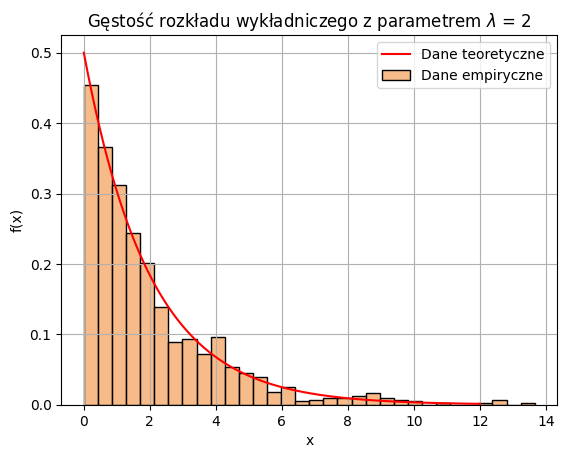

In [ ]:
lamb = 2
wyk = rozklad_wykladniczy(lamb, 1000)
x = np.linspace(0,12,1000)

sns.histplot(wyk, kde=False, color='sandybrown', label='Dane empiryczne', stat='density')
plt.plot(x, expon.pdf(x, 0, lamb),'r',label = 'Dane teoretyczne')
plt.grid()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Gęstość rozkładu wykładniczego z parametrem $\lambda$ = {}".format(lamb))
plt.legend()

Teraz przedstawimy dystrybuantę owego rozkładu:

Text(0.5, 1.0, 'Dystrybuanta rozkładu wykładniczego z parametrem $\\lambda$ = 2')

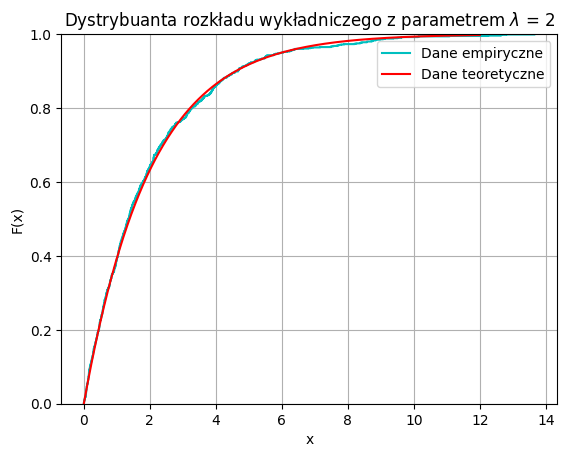

In [ ]:
sns.ecdfplot(wyk, label = "Dane empiryczne", color="c")
plt.plot(x, expon.cdf(x, 0, lamb),'r',label = 'Dane teoretyczne')

plt.legend()
plt.xlabel("x")
plt.ylabel("F(x)")
plt.grid()
plt.title("Dystrybuanta rozkładu wykładniczego z parametrem $\lambda$ = {}".format(lamb))

### 4.4. Zastosowanie metody akceptacji-odrzucenia

Kod programu metody akceptacji-odrzucenia z pomocniczym rozkładem wykładniczym wygląda następująco:

In [ ]:
def akc_odrz_c(c, mi, sigma, n):
    f = lambda x: np.exp(-x**2/2)/np.sqrt(2*np.pi)
    g = lambda x: np.exp(-x)
    result = []
    while n > 0:
        y = rozklad_wykladniczy(1, 1)[0]
        u = random.random()
        if u <= f(y)/(c*g(y)):
            result += [y] 
            n = n-1
    result1 = np.array(result)
    result2 = (-1)*np.array(result)
    return sigma * np.concatenate((result1, result2)) + mi

**Teraz przejdziemy do testowania generatora:**

**Porównanie gęstości teoretycznej i empirycznej**

Text(0.5, 1.0, 'Gęstość r.normalnego N(4,3) (metodą akceptacji-odrzucenia)')

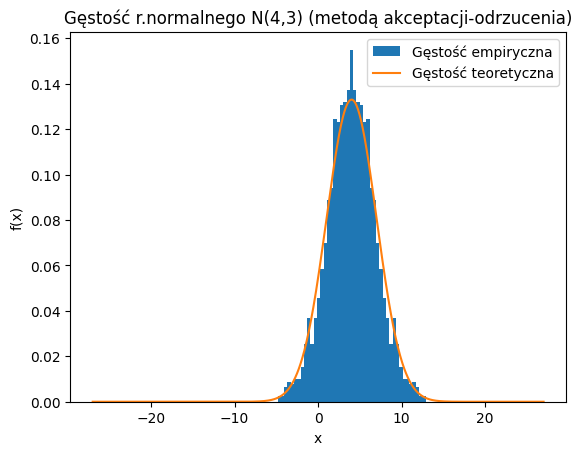

In [ ]:
mi = 4
sigma = 3
c = (math.e/(2*math.pi))**0.5
r = akc_odrz_c(c, mi, sigma, 1000)
x = np.linspace((-3)*3*sigma, 3**2*sigma, 1000)
plt.hist(r, density = True, bins = "sqrt", label = "Gęstość empiryczna" )
plt.plot(x, norm.pdf(x, mi, sigma), label = "Gęstość teoretyczna")
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")

plt.title("Gęstość r.normalnego N({},{}) (metodą akceptacji-odrzucenia)".format(mi, sigma))

**Porównanie teoretycznej i empirycznej dystrybuanty**

Text(0.5, 1.0, 'Dystrybuanta r. normalnego N(4,3) (metodą akceptacji-odrzucenia)')

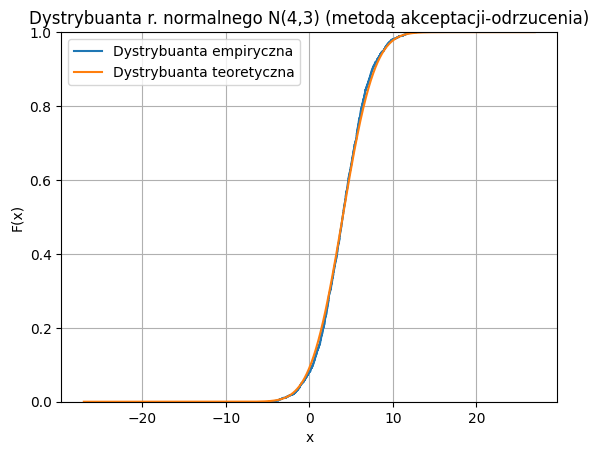

In [ ]:
sns.ecdfplot(r, label = "Dystrybuanta empiryczna")
plt.plot(x, norm.cdf(x, mi, sigma), label = "Dystrybuanta teoretyczna")
plt.legend()
plt.xlabel("x")
plt.grid()
plt.ylabel("F(x)")
plt.title("Dystrybuanta r. normalnego N({},{}) (metodą akceptacji-odrzucenia)".format(mi, sigma))

**Porównanie przybliżenia rozkładu empirycznego oraz teoretycznego**

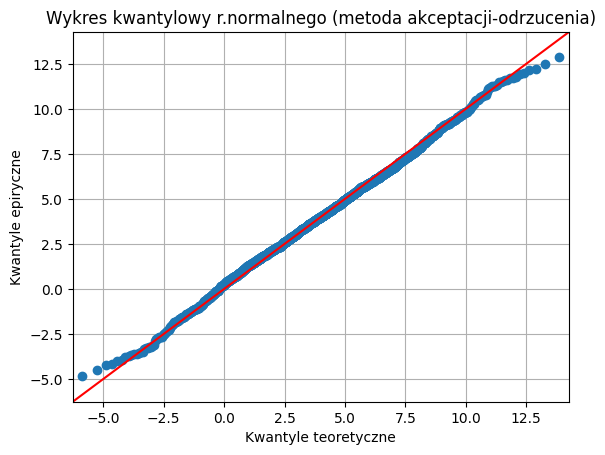

In [ ]:
sm.qqplot(np.array(r), dist = norm(mi, sigma), line = '45');

plt.xlabel("Kwantyle teoretyczne")
plt.ylabel("Kwantyle epiryczne")
plt.title("Wykres kwantylowy r.normalnego (metoda akceptacji-odrzucenia)")
plt.grid()

**Porównanie teoretycznej i empirycznej średniej i wariancji**

In [ ]:
pd.DataFrame([[np.mean(r), norm.mean(mi, sigma)],[np.var(r), norm.var(mi, sigma)]], index=["Średnia", "Wariancja"], columns=["Empirycznie", "Teoretycznie"])


,Empirycznie,Teoretycznie
Średnia,4.00000,4.0
Wariancja,8.19978,9.0


**Porównanie teoretycznej i empirycznej skośności i kurtozy**

Porównamy także *skośność* oraz *kurtozę* korzystając z nieobciążonego estymatora skośności:

$$\hat{s} = \frac{\frac{1}{n}\sum_{i = 1}^{n}(x_i - \overline{x})^3}{(\frac{1}{n-1} \sum_{i = 1}^{n}(x_i - \overline{x})^2)^{\frac{3}{2}}}$$

oraz nieobciążonego estymatora kurtozy:

$$\hat{k} = \frac{(n+1)n(n-1)}{(n-2)(n-3)}\frac{\sum_{i = 1}^{n}(x_i - \overline{x})^4}{(\sum_{i = 1}^{n}(x_i - \overline{x})^2)^2} - 3 \frac{(n-1)^2}{(n-2)(n-3)}$$

Zatem możemy zapisać programy obliczające właśnie skośność i kurtozę:

In [ ]:
def skosnosc(x):
    n = len(x)
    m = np.mean(x)
    return (np.sum((x-m)**3)/((1/(n-1))*np.sum((x-m)**2))**(3/2))/n

In [ ]:
def kurtoza(x):
    n = len(x)
    x1 = (n+1)*n*(n-1)/((n-2)*(n-3))
    x2 = 3*(n-1)**2/((n-2)*(n-3))
    m = np.mean(x)
    return x1*np.sum((x-m)**4)/((np.sum((x - m)**2))**2)-x2

In [ ]:
pd.DataFrame([[skosnosc(r), skew(r)],[kurtoza(r), kurtosis(r)]], index=["Skośność", "Kurtoza"], columns=["Empirycznie", "Teoretycznie"])


,Empirycznie,Teoretycznie
Skośność,0.000000,0.000000
Kurtoza,0.096694,0.093454


### 4.5. Wnioski

Po przeprowadzeniu symulacji i analizie wyników dla rozkładu normalnego, możemy stwierdzić, że metoda akceptacji-odrzucenia z wykorzystaniem rozkładu wykładniczego jest skuteczną metodą generowania tego rozkładu.
Na histogramie możemy zauważyć odrzucone wartości. Ta obserwacja może sugerować, że metoda ta może mieć ograniczoną dokładność w generowaniu rozkładu.

## 5. Metoda Boxa-Mullera

### 5.1. Opis metody

Rozkład normalny jest bardzo istotnym rozkładem w dziedzinie statystyki i prawdopodobieństwa. Zatem nie jest nietypowym to, że istnieje wiele metod jego generowania. Jedną z takich metod jest metoda Boxa-Mullera. 

Ową metodę najlepiej opisuje następujące twierdzenie:


Załóżmy że $U_{1}, U_{2}$ - iid. gdzie każda z tych zmiennych ma rozkład $\mathcal{U}(0,1)$. 

Jeśli zdefiniujemy dwie zmienne losowe $X$ i $Y$ jako:

<center>$X = \sqrt{-2  \ln(U_{1})} \cdot \cos(2 \pi U_{2})$</center>


<center>$Y = \sqrt{-2  \ln(U_{1})} \cdot \sin(2 \pi U_{2})$</center>


To wówczas zmienne $X$ i $Y$ są niezależne i obie mają rozkład normalny standardowy $N(0,1)$.

### 5.2. Algorytm metody

Na podstawie powyższego opisu powstał poniższy **algorytm**:
1. Generujemy $U_{1},U_{2} \thicksim \mathcal{U}(0,1)$ takie że $U_{1} \bot U_{2} $.
2. Zwracamy dwie zmienne losowe: 

<center>$X = \sqrt{-2  \ln(U_{1})} \cdot \cos(2 \pi U_{2})$</center>


<center>$Y = \sqrt{-2  \ln(U_{1})} \cdot \sin(2 \pi U_{2})$</center>

które są z rozkładu normalnego $N(0,1)$.

Korzystając z transformacji liniowej możemy generować zmienną losową z rozkładu $N(\mu, \sigma)$. 

W taki sposób iż generujemy zmienną losową $X_{0} \thicksim N(0,1)$, a następnie generujemy zmienną $X=\sigma X_{0} + \mu$ i wówczas $X \thicksim N(\mu, \sigma)$.

### 5.3. Zastosowanie metody Boxa-Mullera

Kod generatora zmiennych z rozkładu normalnego przy pomocy metody Boxa-Mullera wygląda następująco:

In [ ]:
def norm_generator_bm(mi, sigma, n):
    u1 = np.random.uniform(size=n)
    u2 = np.random.uniform(size=n)
    R = np.sqrt((-2) * np.log(u1))
    teta = 2 * np.pi * u2
    X1 = R * np.cos(teta)
    Y1 = R * np.sin(teta)
    X = sigma * X1 + mi
    Y = sigma * Y1 + mi

    return X, Y

# funkcja gęstości rozkładu normalnego N(0,1)
def normal_gestosc(x, mi, sigma):
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(x-mi)**2/(2*sigma**2))


**Teraz przejdziemy do testowania generatora:**

**Porównanie gęstości teoretycznej i empirycznej**

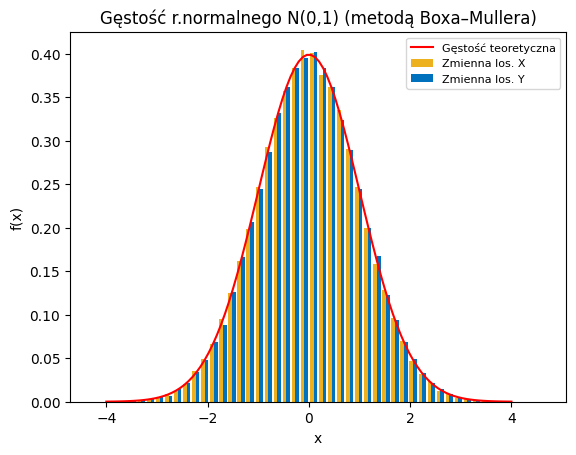

In [ ]:
mi = 0
sigma = 1
n = 100000
probki = norm_generator_bm(mi, sigma, n)
d = np.linspace(-4,4,100)

plt.plot(d, normal_gestosc(d, mi ,sigma), color="red", label="Gęstość teoretyczna")
plt.hist(probki, bins=50, density=True, color=[	"#EDB120", "#0072BD"] ,label=["Zmienna los. X", "Zmienna los. Y"])
plt.title("Gęstość r.normalnego N({},{}) (metodą Boxa–Mullera)".format(mi, sigma))
plt.legend(loc="upper right", fontsize=8)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

**Porównanie teoretycznej i empirycznej dystrybuanty**

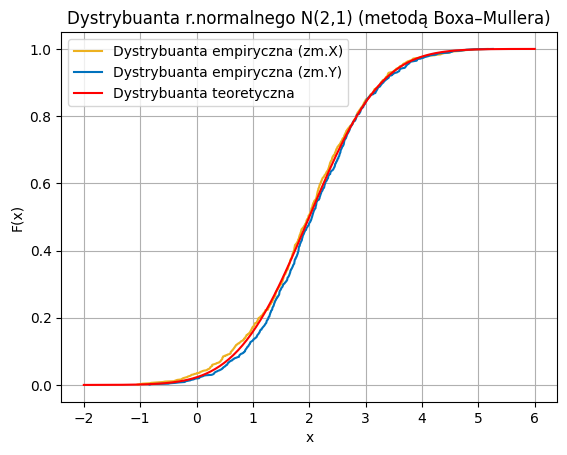

In [ ]:
mi = 2
sigma = 1
n = 800

x1, _ = norm_generator_bm(mi, sigma, n)
_, y2 = norm_generator_bm(mi, sigma, n)
ecdf1 = ECDF(x1)
plt.plot(ecdf1.x, ecdf1.y, label="Dystrybuanta empiryczna (zm.X)", color="#EDB120")
ecdf2 = ECDF(y2)
plt.plot(ecdf2.x, ecdf2.y, label="Dystrybuanta empiryczna (zm.Y)", color="#0072BD")

d = np.linspace(-2, 6, 200)
plt.plot(d, norm.cdf(d, 2, 1), label="Dystrybuanta teoretyczna", color="red")
plt.title("Dystrybuanta r.normalnego N({},{}) (metodą Boxa–Mullera)".format(mi,sigma))
plt.ylabel('F(x)')
plt.xlabel("x")
plt.legend()
plt.grid()
plt.show()

**Porównanie przybliżenia rozkładu empirycznego oraz teoretycznego**

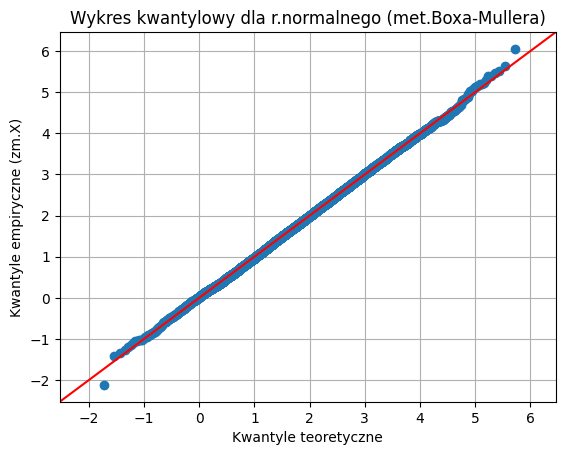

In [ ]:
mi = 2
sigma = 1
n = 10000

x1, _ = norm_generator_bm(mi, sigma, n)
_, y2 = norm_generator_bm(mi, sigma, n)

sm.qqplot(x1, line="45", dist=norm(mi, sigma))
plt.ylabel("Kwantyle empiryczne (zm.X)")
plt.xlabel("Kwantyle teoretyczne")

plt.title("Wykres kwantylowy dla r.normalnego (met.Boxa-Mullera)")
plt.grid()
plt.show()

**Porównanie teoretycznej i empirycznej średniej i wariancji**

In [ ]:
mi = 2
sigma = 1
n = 1000

probki_X, probki_Y = norm_generator_bm(mi, sigma, n)
print("Dla zmiennej losowej X") 
pd.DataFrame([[np.mean(probki_X), norm.mean(mi, sigma)],[np.var(probki_X), norm.var(mi, sigma)]], index=["Średnia", "Wariancja"], columns=["Empirycznie", "Teoretycznie"])

Dla zmiennej losowej X


,Empirycznie,Teoretycznie
Średnia,1.997978,2.0
Wariancja,0.974266,1.0


In [ ]:
print("Oraz dla zmiennej losowej Y")
pd.DataFrame([[np.mean(probki_Y), norm.mean(mi, sigma)],[np.var(probki_Y), norm.var(mi, sigma)]], index=["Średnia", "Wariancja"], columns=["Empirycznie", "Teoretycznie"])

Oraz dla zmiennej losowej Y


,Empirycznie,Teoretycznie
Średnia,1.943951,2.0
Wariancja,1.028533,1.0


**Porównanie teoretycznej i empirycznej skośności i kurtozy**

In [ ]:
probki_X, probki_Y = norm_generator_bm(mi, sigma, n)
print("Dla zmiennej losowej X") 
pd.DataFrame([[skosnosc(probki_X), skew(probki_X)],[kurtoza(probki_X), kurtosis(probki_X)]], index=["Skośność", "Kurtoza"], columns=["Empirycznie", "Teoretycznie"])

Dla zmiennej losowej X


,Empirycznie,Teoretycznie
Skośność,-0.072298,-0.072407
Kurtoza,-0.108785,-0.114236


In [ ]:
print("Dla zmiennej losowej Y") 
pd.DataFrame([[skosnosc(probki_Y), skew(probki_Y)],[kurtoza(probki_Y), kurtosis(probki_Y)]], index=["Skośność", "Kurtoza"], columns=["Empirycznie", "Teoretycznie"])

Dla zmiennej losowej Y


,Empirycznie,Teoretycznie
Skośność,-0.046868,-0.046938
Kurtoza,-0.407325,-0.411286


### 5.4. Wnioski
Po przeanalizowaniu wizualizacji i wyników dla rozkładu normalnego możemy stwierdzić iż metoda Boxa-Mullera jest metodą poprawną. Zauważamy że na wykresach dystrybuanty, gęstości oraz na wykresie kwantylowym wartości teoretyczne niemal idealnie pokrywają się wartościami empirycznymi, co wskazuje na dużą dokładność owej metody.


## 6. Metoda biegunowa


### 6.1. Opis metody

Kolejną metodą generowania rozkładu normalnego jest metoda biegunowa. Pozwala ona na wygenerowane dwóch zmiennych losowych z rozkładu normalnego tak jak w metodzie Boxa-Mullera. 
Jednakże metoda Boxa-Mullera posiada mankament, ponieważ wykorzystuje ona funkcje $sin$ i $cos$ które są dość czasochłonne. 

Dlatego właśnie powstała metoda biegunowa, którą możemy opisać następująco:

Załóżmy, że dwuwymiarowy wektor losowy $(V_{1}, V_{2})$ ma rozkład jednostajny w kole jednostkowym.

Definiujemy $V_{1} = R\cos(\alpha) , V_{2} = R\sin(\alpha)$ (współrzędne biegunowe).
Dokonując odpowiednich przekształceń zobaczymy, że: 
<center> $\alpha \thicksim \mathcal{U}(0,2\pi),$ $\space $ $R^{2} \thicksim \mathcal{U}(0,1)$ $\space $ oraz  $\alpha \bot R^{2}$.</center>


Teraz aby wyznaczyć wzory bez wykorzystywania funkcji $sin$ i $cos$ musimy przekształcić wzory użyte w metodzie Boxa-Mullera:

Najpierw dokonujemy przejść: $ U_{1} \to R^{2} $, $ (2 \pi U_{2}) \to \alpha $, a potem podstawiamy.


<center>$X = \sqrt{-2  \ln(U_{1})} \cdot \cos(2 \pi U_{2}) = \sqrt{-2  \ln(R^{2})} \cdot \cos(\alpha) = \sqrt{-2  \ln(R^{2})} \cdot \frac{V_{1}}{R} = \sqrt{ \frac{-2 \ln(R^{2})}{R^{2}} } \cdot V_{1} $</center>

<center>$Y = \sqrt{-2  \ln(U_{1})} \cdot \sin(2 \pi U_{2}) = \sqrt{-2  \ln(R^{2})} \cdot \sin(\alpha) = \sqrt{-2  \ln(R^{2})} \cdot \frac{V_{2}}{R} = \sqrt{ \frac{-2 \ln(R^{2})}{R^{2}} } \cdot V_{2}$</center>

Takim sposobem zmienne $X$ i $Y$ mają standardowy rozkład normalny i są niezależne.

### 6.2. Algorytm metody
Na podstawie tego opisu powstał poniższy algorytm:
1. Generujemy $V_{1},V_{2} \thicksim \mathcal{U}(-1,1)$ takie że $V_{1} \bot V_{2} $.
2. Wyznaczamy $R^{2} = V_{1}^{2} + V_{2}^{2}$.
3. Jeżeli $R^{2} > 1 $ to wróć do 1. 
4. Jeśli $R^{2} \leq 1 $ to zwróć zmienne:

<center>$X = \sqrt{ \frac{-2 \ln(R^{2})}{R^{2}} } \cdot V_{1} $</center>

<center>$Y = \sqrt{ \frac{-2 \ln(R^{2})}{R^{2}} } \cdot V_{2}$</center>
które są z rozkładu normalnego $N(0,1)$.

Podobnie jak w metodzie Boxa-Mullera możemy generować zmienną losową z rozkładu $N(\mu, \sigma)$ korzystając z transformacji liniowej.

### 6.3. Zastosowanie metody biegunowej

Kod generatora zmiennych z rozkładu normalnego przy pomocy metody biegunowej wygląda następująco:

In [ ]:
def met_biegunowa(mi, sigma, n):
    xs = np.zeros(n)
    ys = np.zeros(n)
    for i in range(n):
        v1 = np.random.uniform(-1, 1, size=1)
        v2 = np.random.uniform(-1, 1, size=1)
        R = np.sqrt(v1 ** 2 + v2 ** 2)
        R2 = R ** 2

        if R2 <= 1:
            X1 = np.sqrt((-2) * np.log(R2) / R2) * v1
            Y1 = np.sqrt((-2) * np.log(R2) / R2) * v2
            xs[i] = sigma * X1 + mi
            ys[i] = sigma * Y1 + mi
    return xs[xs != 0], ys[ys != 0]

**Teraz przejdziemy do testowania generatora:**

**Porównanie gęstości teoretycznej i empirycznej**

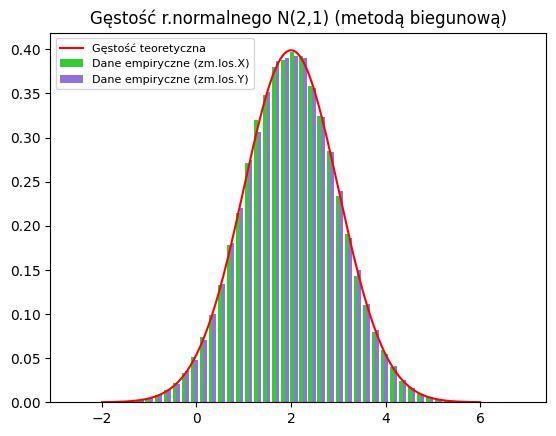

In [ ]:
n = 100000
probki = met_biegunowa(mi, sigma, n)

d = np.linspace(-2, 6, 200)
plt.plot(d, normal_gestosc(d, mi, sigma), color="red", label="Gęstość teoretyczna")

plt.hist(probki, bins=50, density=True, color=["limegreen", "mediumpurple"], label=["Dane empiryczne (zm.los.X)", "Dane empiryczne (zm.los.Y)"])
plt.title("Gęstość r.normalnego N({},{}) (metodą biegunową)".format(mi, sigma))
plt.legend(loc="upper left",fontsize=8)
plt.show()

**Porównanie dystrybuanty teoretycznej i empirycznej**

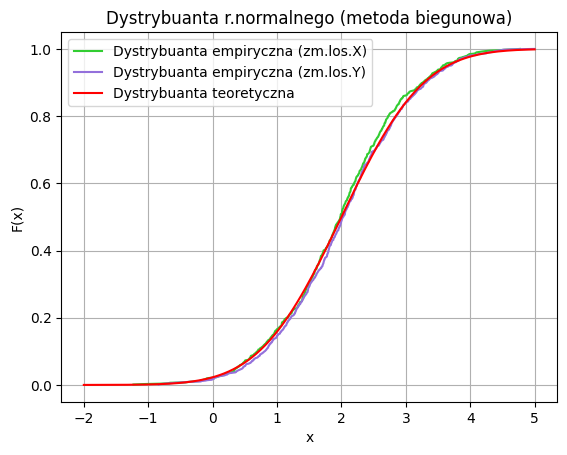

In [ ]:
n = 1000

x1, _ = met_biegunowa(mi, sigma, n)
_, y2 = met_biegunowa(mi, sigma, n)

ecdf1 = ECDF(x1)
plt.plot(ecdf1.x, ecdf1.y, label="Dystrybuanta empiryczna (zm.los.X)", color="limegreen")
ecdf2 = ECDF(y2)
plt.plot(ecdf2.x, ecdf2.y, label="Dystrybuanta empiryczna (zm.los.Y)", color="mediumpurple")

d = np.linspace(-2, 5, 200)
plt.plot(d, norm.cdf(d, mi, sigma), label="Dystrybuanta teoretyczna", color="red")
plt.legend()
plt.title("Dystrybuanta r.normalnego (metoda biegunowa)")
plt.ylabel("F(x)")
plt.grid()
plt.xlabel("x")
plt.show()

**Porównanie przybliżenia rozkładu empirycznego oraz teoretycznego**

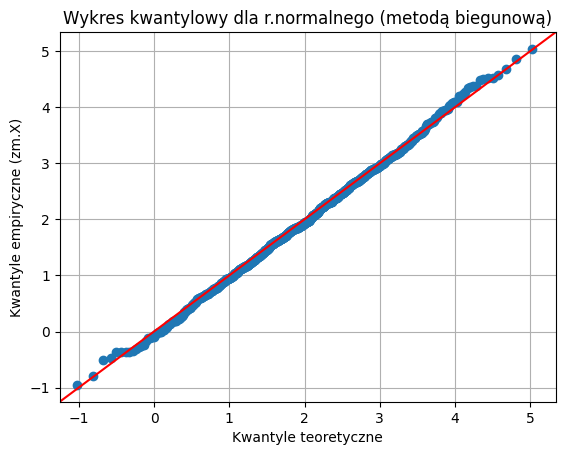

In [ ]:
n = 1000

x1, _ = met_biegunowa(mi, sigma, n)
_, y2 = met_biegunowa(mi, sigma, n)

sm.qqplot(x1, line="45", dist=norm(mi, sigma))
plt.ylabel("Kwantyle empiryczne (zm.X)")
plt.xlabel("Kwantyle teoretyczne")
plt.grid()
plt.title("Wykres kwantylowy dla r.normalnego (metodą biegunową)")
plt.show()

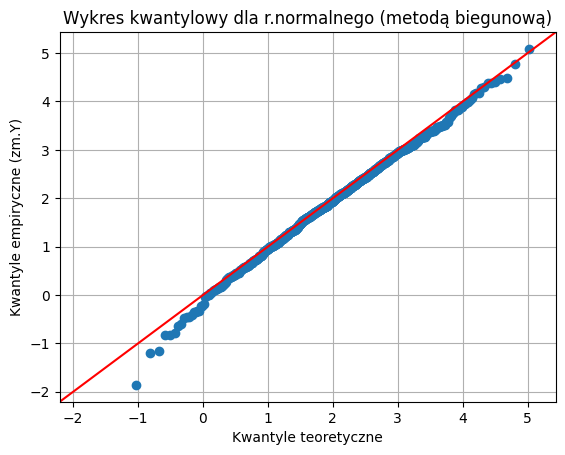

In [ ]:
sm.qqplot(y2, line="45", dist=norm(mi, sigma))
plt.ylabel("Kwantyle empiryczne (zm.Y)")
plt.xlabel("Kwantyle teoretyczne")
plt.grid()
plt.title("Wykres kwantylowy dla r.normalnego (metodą biegunową)")
plt.show()

**Porównanie teoretycznej i empirycznej średniej i wariancji**

In [ ]:
mi = 2
sigma = 1
n = 10000

probkiX, probkiY = met_biegunowa(mi, sigma, n)

print("Dla zmiennej losowej X") 
pd.DataFrame([[np.mean(probkiX), norm.mean(mi, sigma)],[np.var(probkiX), norm.var(mi, sigma)]], index=["Średnia", "Wariancja"], columns=["Empirycznie", "Teoretycznie"])

Dla zmiennej losowej X


,Empirycznie,Teoretycznie
Średnia,1.988072,2.0
Wariancja,0.986723,1.0


In [ ]:
print("Oraz dla zmiennej losowej Y")
pd.DataFrame([[np.mean(probkiY), norm.mean(mi, sigma)],[np.var(probkiY), norm.var(mi, sigma)]], index=["Średnia", "Wariancja"], columns=["Empirycznie", "Teoretycznie"])

Oraz dla zmiennej losowej Y


,Empirycznie,Teoretycznie
Średnia,2.032267,2.0
Wariancja,1.005772,1.0


**Porównanie teoretycznej i empirycznej kurtozy i skośności**

In [ ]:
print("Dla zmiennej losowej X") 
pd.DataFrame([[skosnosc(probkiX), skew(probkiX)],[kurtoza(probkiX), kurtosis(probkiX)]], index=["Skośność", "Kurtoza"], columns=["Empirycznie", "Teoretycznie"])

Dla zmiennej losowej X


,Empirycznie,Teoretycznie
Skośność,-0.000520,-0.000520
Kurtoza,-0.039487,-0.040225


In [ ]:
print("Dla zmiennej losowej Y") 
pd.DataFrame([[skosnosc(probkiY), skew(probkiY)],[kurtoza(probkiY), kurtosis(probkiY)]], index=["Skośność", "Kurtoza"], columns=["Empirycznie", "Teoretycznie"])

Dla zmiennej losowej Y


,Empirycznie,Teoretycznie
Skośność,-0.023629,-0.023633
Kurtoza,0.004713,0.003947


### 6.4. Wnioski
Po dokładnej analizie przeprowadzonych symulacji i analizie wyników można zauważyć, że metoda biegunowa jest skuteczną i satysfakcjonującą metodą generowania rozkładu normalnego. Dodatkowo w porównaniu z metodą Boxa-Mullera, metoda biegunowa nie wymaga użycia funkcji trygonometrycznych, co może przyspieszyć proces generowania próbek.

## 7. Badanie czasu działania metod generowania rozkładu normalnego

Teraz skupimy się na **porównaniu czasu działania metod generowania r. normalnego ze względu na długość próbki.** 

Celem jest znalezienie metody, która pozwala na wydajne i szybkie generowanie dużej liczby próbek, co jest istotne w przypadku symulacji i analizy danych.

Porównamy następujące metody :
- metody akceptacji-odrzucenia przy wykorzystaniu rozkładu wykładniczego
- metody Boxa-Mullera
- metody biegunowej

Poniżej znajduje się kod odpowiedzialny za pomiar czasu oraz tworzenie listy o zadanych długościach próbki $n$.


In [ ]:
ns = [i for i in range(1000, 10000, 1000)]
ts_a = np.zeros(len(ns))
ts_bm = np.zeros(len(ns))
ts_b = np.zeros(len(ns))
mi = 2
sigma = 1
c = (math.e/2*math.pi)**0.5

i = 0
for n in ns:
  start = time.time()
  r = akc_odrz_c(c, mi, sigma, n)
  end = time.time()
  ts_a[i] = end - start

  start = time.time()
  x1, y1 = norm_generator_bm(mi, sigma, n)
  end = time.time()
  ts_bm[i] = end - start

  start = time.time()
  x2, y2  = met_biegunowa(mi, sigma, n)
  end = time.time()
  ts_b[i] = end - start

  i = i + 1

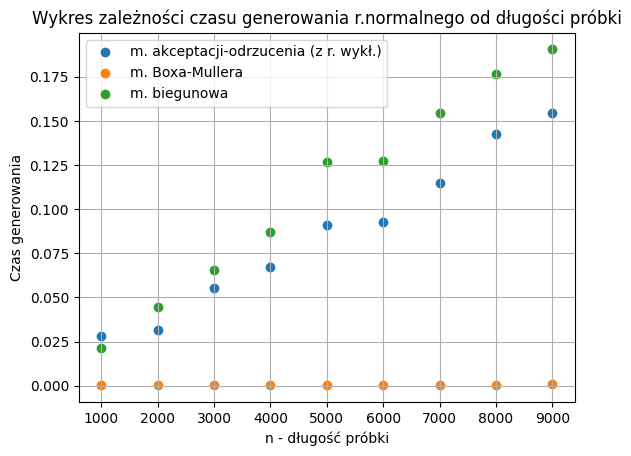

In [ ]:
plt.scatter(ns, ts_a, label = "m. akceptacji-odrzucenia (z r. wykł.)")
plt.scatter(ns, ts_bm, label = "m. Boxa-Mullera")
plt.scatter(ns, ts_b, label = "m. biegunowa")

plt.title("Wykres zależności czasu generowania r.normalnego od długości próbki")
plt.xlabel("n - długość próbki")
plt.ylabel("Czas generowania")
plt.legend()
plt.grid()

**Wnioski z badania czasu działania metod:**

Z wizualizacji można zauważyć pewną zależność liniową między czasem generowania, a długością próbki. Jednak najważniejszym wnioskiem jest to, że metoda Boxa-Mullera jest jednoznacznie najszybszą z omówionych metod. Pozostałe dwie mają zbliżony do siebie czas działania z niewielką przewagą dla metody akceptacji-odrzucenia. 

Metoda biegunowa wykorzystuje transformację polarną współrzędnych, aby uzyskać dwie niezależne zmienne losowe z rozkładu normalnego, dlatego wydaje się bardziej złożona i bardziej czasochłonna niż m. Boxa Mullera. Natmiast metoda akceptacji-odrzucenia również jest mniej wydajna, ponieważ generuje większą liczbę próbek, aby móc mieć większy wybór między próbkami poprawnymi oraz tymi do odrzucenia.

W zależności od priorytetów - szybkości, wydajności czy dokładności, różne metody mogą być bardziej lub mniej odpowiednie. Przykładowo, jeśli potrzebujemy wygenerować dużą liczbę próbek z rozkładu normalnego i możemy pozwolić sobie na bardziej skomplikowane obliczenia, to metoda biegunowa lub metoda odrzucania mogą być dokładniejsze niż metoda Boxa-Mullera. Natomiast jeśli szybkość jest kluczowa, to metoda Boxa-Mullera będzie lepszym wyborem.


## 8. Algorytm Ziguratta

### 8.1. Opis algorytmu

*Algorytm Ziggurata* służy do generowania realizacji zmiennej losowej z rozkładu o ściśle malejącej gęstości w sposób szybki efektywny. Za pomocą tego algorytmu wygenerujemy rozkład *Pareto*$(\alpha, \mu)$, gdzie parametr $\alpha$ jest parametrem kształtu, natomiast $\mu$ jest parametrem skali dla tego rozkładu. 

Dla $X$~*Pareto*$(\alpha,\mu)$ gęstość oraz dystrybuanta wyrażają się wzorami:

$$F_X(x) = \begin{cases} 1 - \left(\frac{\mu}{x}\right)^\alpha &\text{dla} \ x\ge\mu \\ 0 &\text{dla} \ x<\mu
\end{cases}$$

$$f_X(x) = \begin{cases} \frac{\alpha \mu^\alpha}{x^{\alpha+1}} &\text{dla} \ x\ge\mu \\ 0 &\text{dla} \ x<\mu
\end{cases}$$


Aby przejść do opisu algorytmu Ziguratta, musimy najpierw wyznaczyć wartość $v$ - pola dla każdego z 256 prostokątów. Dokonujemy tego przez obliczenie całki oznaczonej: $$ v = rf(r) + \int_r^{∞}f(x) \text{d}x = r \frac{\alpha \mu^α}{r^{\alpha +1}} + \int_r^{∞}\frac{\alpha \mu^α}{x^{\alpha +1}} \text{d}x = r \frac{\alpha \mu^α}{r^{\alpha +1}} + \left(\frac{\mu}{r}\right)^\alpha$$
Zauważamy, że $v(x)$ uzależnione jest od dwóch parametrów: $\alpha, \mu$.

Realizację $x$ z ogona rozkładu wygenerowano za pomocą metody odwrotnej dystrybuanty (dla rozkładu ciągłego).

Generowanie $r$ uzależnione jest od parametru $\epsilon$, który ustala użytkownik, wywołując funkcję **pareto_zig:**

Aby poprawnie skorzystać z algorytmu wyznaczmy teoretycznie dystrybuatnę oraz gęstość odwrotną. 

Odwrotna funkcja dystrybuanty:
$$ y = 1- \left(\frac{\mu}{x}\right)^\alpha$$
$$ x = \frac{\mu}{\sqrt[\alpha]{1-y}}$$

Oraz odwrotna funkcja gęstości:

$$y =  \frac{\alpha \mu^\alpha}{x^{\alpha+1}}$$
$$x = \sqrt[\alpha+1]{\frac{\alpha \mu ^\alpha}{y}}$$

Przybliżenie $\epsilon$, które będzie jednym z parametrów funkcji, pozwala na wyznaczenie takiego $r$, aby spełniona była nierówność:

$$|v-x_1+x_1f(x_1)| < ϵ$$

Ogólny algorytm oraz generowanie wektorów $k$ oraz $w$ zostało ujęte w treści zadania, natomiast realizacja tego polecenia przedstawiona jest poniżej w programie:

In [ ]:
def odwr_dyst(x, mu, alpha):
  return mu/((x)**(1/alpha))

In [ ]:
def odwr_den(x, mu, alpha):
  return (alpha*mu**alpha/x)**(1/(alpha+1))

In [ ]:
def gen_den(x, mu, alpha):
    return alpha*mu**alpha/(x**(alpha+1))

In [ ]:
def gen_constans(r, mu, alpha):
  n = 256
  x_i = np.zeros(n)
  k_i = np.zeros(n)
  w_i = np.zeros(n)
  f_r = gen_den(r, mu, alpha)
  v = r*f_r + (alpha/r)**alpha
  x_i[-1] = r
  for i in range(254, 0, -1):
    den = v/x_i[i+1] + gen_den(x_i[i+1], mu, alpha)
    x_i[i] = odwr_den(den, mu, alpha)
  k_i[0] = math.floor(2**32*r*f_r/v)
  w_i[0] = 0.5**32*v/f_r 
  for i in range(1, 256):
    k_i[i] = math.floor(2**32*x_i[i-1]/x_i[i])
    w_i[i] = 0.5**32*x_i[i]
  return k_i, w_i, x_i, v

In [ ]:
def gen_x_v(r, mu, alpha):
  n = 256
  x_i = np.zeros(n)
  f_r = gen_den(r, mu, alpha)
  v = r*f_r + (alpha/r)**alpha
  x_i[-1] = r
  for i in range(254, 0, -1):
    den = v/x_i[i+1] + gen_den(x_i[i+1], mu, alpha)
    x_i[i] = odwr_den(den, mu, alpha)
  return x_i, v

In [ ]:
def tail_r(epsilon, mu, alpha):
  r = 0.1
  x, v = gen_x_v(r, mu, alpha)
  while math.fabs(v - x[1] +x[1]*gen_den(x[1], mu, alpha)) >= epsilon:
    x, v = gen_x_v(r, mu, alpha)
    r = r + 0.1
  return r

In [ ]:
def pareto_zig(epsilon, mu, alpha, n, t = False):
    r = tail_r(epsilon, mu, alpha)  #ogon

    if t is True:
      return r
      
    k, w, x, v = gen_constans(r, mu, alpha)
    f_x = [gen_den(y, mu, alpha) for y in x]

    results = []

    while n != 0:
      j = random.randint(0, 2**32)
      b_j = bin(j)
      i_b = b_j[-8:]
      i = int(i_b, 2)
      x = j*w[i]

      if x >= mu: #tylko wtedy gestosc i dystrybuanta != 0
        u = random.random()
        if j < k[i]:
          results.append(x)
          n = n - 1

        elif i == 0:
          results.append(odwr_dyst(x, mu, alpha)+mu)
          n = n - 1

        elif (f_x[i-1]-f_x[i])*u < (gen_den(x, mu, alpha) - f_x[i]):
          results.append(x)
          n = n - 1
   
    return results

### 8.2. Zastosowanie algorytmu Ziggurat

**Teraz przeprowadzimy test poprawności działania algorytmu Ziggurata.**

Zaczniemy od wyznaczenia **empirycznej i teoretycznej gęstości** dla próby z rozkładu Pareto z parametrem  $\alpha$ oraz $\mu$  o dlugości n oraz z przybliżeniem $\epsilon$ porównamy ich stopień pokrycia z wizualizacji.

<ipython-input-200-28744d29827e>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return alpha*mu**alpha/(x**(alpha+1))


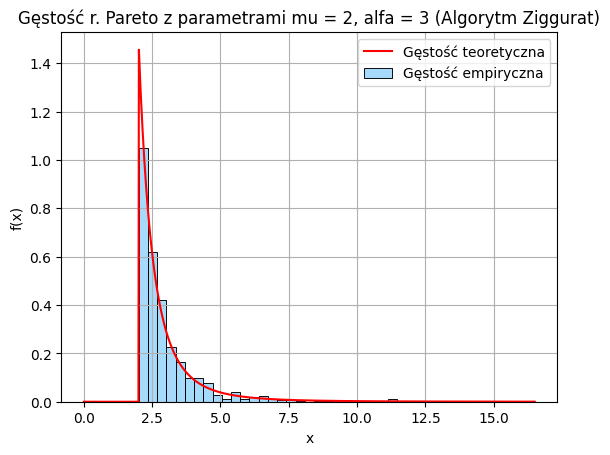

In [ ]:
mu = 2
alpha = 3
n = 10000
epsilon = 0.01
r = pareto_zig(epsilon, mu, alpha, 1000, True)
x = np.linspace(0, r, 1000)
par = pareto_zig(epsilon, mu, alpha, 1000, False)

plt.plot(x, pareto.pdf(x, alpha, scale = mu), label = "Gęstość teoretyczna", color="red")
sns.histplot(par, bins="sqrt", kde=False, color='lightskyblue', stat='density', label = "Gęstość empiryczna")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Gęstość r. Pareto z parametrami mu = {}, alfa = {} (Algorytm Ziggurat)".format(mu, alpha));

Podobnie porównamy obie **empiryczną i teoretyczną dystrybuantę**:

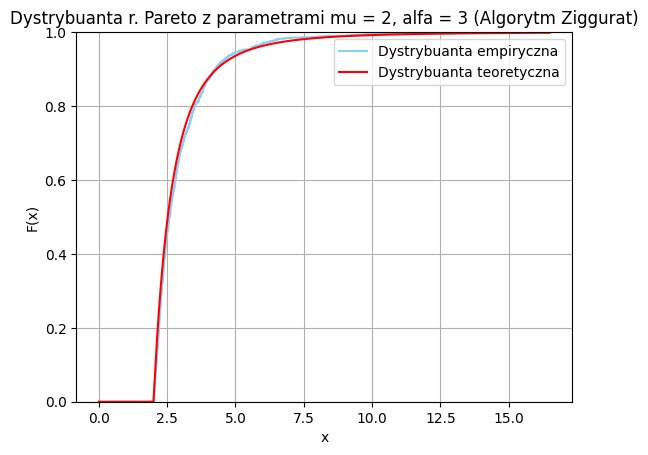

In [ ]:
sns.ecdfplot(par, label = "Dystrybuanta empiryczna", color="lightskyblue")
plt.plot(x, pareto.cdf(x, alpha, scale = mu), label = "Dystrybuanta teoretyczna", color="red")
plt.legend()
plt.xlabel("x")
plt.grid()
plt.ylabel("F(x)")
plt.title("Dystrybuanta r. Pareto z parametrami mu = {}, alfa = {} (Algorytm Ziggurat)".format(mu, alpha));

W kolejnym teście wygenerujemy **QQ-plot**, aby porównać rozkład empiryczny z teoretycznym.

Text(0.5, 1.0, 'Wykres kwantylowy dla r. Pareto (Algorytm Ziggurat)')

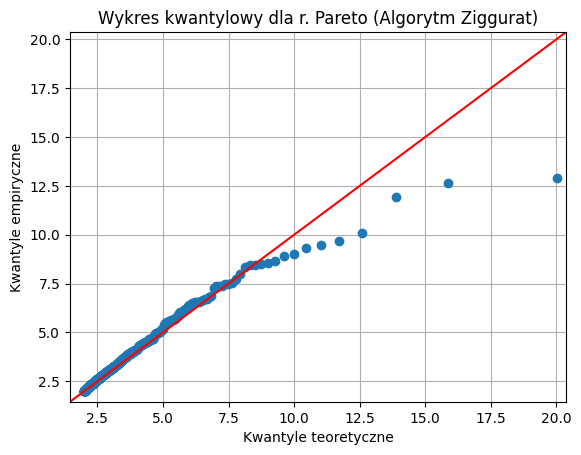

In [ ]:
sm.qqplot(np.array(par), dist = pareto(alpha, scale = mu), line = '45');
plt.grid()
plt.xlabel("Kwantyle teoretyczne")
plt.ylabel("Kwantyle empiryczne")
plt.title("Wykres kwantylowy dla r. Pareto (Algorytm Ziggurat)")

Ostatecznie porównamy **średnią oraz wariancję** naszej próbki z teoretycznymi wartościami dla rozkładu *Pareto*

In [ ]:
pd.DataFrame([[np.mean(par), pareto.mean(alpha, scale = mu)],[np.var(par), pareto.var(alpha, scale = mu)]], index=["Średnia", "Wariancja"], columns=["Empirycznie", "Teoretycznie"])


,Empirycznie,Teoretycznie
Średnia,3.061384,3.0
Wariancja,1.764508,3.0


### 8.3. Wnioski
Najważniejszym wnioskiem z przeprowadzonych wizualizacji i wyników jest fakt, że algorytm Ziguratta jest skuteczną metodą generowania próbek z rozkładu Pareto. Algorytm Ziguratta jest bardzo wydajny, gdyż wykorzystuje specjalnie przygotowane prostokąty, co pozwala na uniknięcie operacji mnożenia i dzielenia, które są dość kosztowne obliczeniowo.

## 9. Podsumowanie i wnioski

W raporcie przedstawiliśmy różne metody generowania zmiennych losowych dla zadanych rozkładów (zarówno dla rozkładów ciągłych jak i dyskretnych). Do każdej procedury ustaliliśmy założenia oraz zaprezentowaliśmy ogólny algorytm. Opisy zaprezentowane w raporcie zostały przedstawione z wiedzy wyniesionej z laboratoriów oraz wykładu *Symulacje komputerowe*. Metody, którymi się posłużyliśmy, to kolejno:
* metoda odwrotnej dystrybuanty
* metoda akceptacji i odrzucenia

Generowaliśmy także rozkład normalny przy użyciu następujących metod:
* metoda Boxa Mullera
* metoda biegunowa
* metoda akceptacji-odrzucenia przy użyciu rozkładu wykładniczego
Dodatkowo za pomocą Algorytmu Ziggurata wygenerowaliśmy rozkład Pareto. 

Przetestowaliśmy wygenerowane próbki z teoretycznymi rozkładami, wizualizując ich dystrybuanty, histogramy, generując QQ-ploty (wykresy kwantylowe) oraz obliczając średnią oraz wariancję wysymulowanej próbki. W rozkładach dyskretnych sprawdzaliśmy rozkład prawdopodobieństwa z teoretycznym, natomiast w ciągłych - histogram z gęstością teoretyczną. Dla każdego testu priorytetem było porównanie jakości pokrycia z teoretycznymi wartościami, aby dopiero stwierdzić, że poprawnie wygenerowano rozkład empiryczny.

W rozkładach normalnych wyznaczyliśmy także inne charakterystyki - skośność i kurtozę, które pozwalają na bliższe porównanie próbki z teoretycznymi wartościami generowanego rozkładu.

Dzięki przeprowadzonym obserwacjom możemy wysnuć wnioski, że metody są poprawnie zaimplementowane, ponieważ statystyki pokrywają się z założeniami teoretycznymi. Dodatkowo przetestowaliśmy szybkość działania metod generujących rozkład normalny w zależności od długości próbki. Metoda Boxa-Mullera okazała się znacznie korzystniejsza. Odrzucanie większości potencjalnych próbek znacznie wydłużyły czas działania algorytmów, co przełożyło się na ich efektywność, lecz są one znacznie dokładniejsze w porównaniu do metody Boxa-Mullera. 

